In [2]:
!pip install jupytext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 kB 3.7 MB/s eta 0:00:00


<a href="https://colab.research.google.com/github/iAAA-event/iAAA-MRI-Contest-Image/blob/main/iaaa_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [ ]:
! pip install SimpleITK
! pip install pydicom
! pip install "numpy<2" "tensorflow==2.15" "keras==2.15"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installati

Clone the repository:

In [ ]:
!git clone https://github.com/iAAA-event/iAAA-MRI-Challenge.git

Cloning into 'iAAA-MRI-Challenge'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 20 (delta 4), reused 9 (delta 3), pack-reused 9 (from 1)
Receiving objects: 100% (20/20), 135.10 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cpu


Unzip data:

In [ ]:
!unzip /content/iAAA-MRI-Challenge/MRI_Labeling_normal_abnormal_SPI_p0_s0.zip -d ~/dataJ

Archive:  /content/iAAA-MRI-Challenge/MRI_Labeling_normal_abnormal_SPI_p0_s0.zip
replace /root/dataJ/MRI_Labeling_normal_abnormal_SPI_p0_s0/labels_dictionary.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Prepare Data

Define paths:

In [ ]:
from pathlib import Path


ROOT_DATA_DIR = Path('~/data/MRI_Labeling_normal_abnormal_SPI_p0_s0').expanduser().absolute()
DATA_DIR = ROOT_DATA_DIR / 'data'
LABELS_PATH = ROOT_DATA_DIR / 'labels.csv'
PREPARED_DATA_DIR = Path('~/prepared_data').expanduser().absolute()
print(DATA_DIR)
print(LABELS_PATH)
print(PREPARED_DATA_DIR)

/root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data
/root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/labels.csv
/root/prepared_data


Define helper functions:

In [ ]:
from typing import Optional

import numpy as np
import pydicom
import SimpleITK as sitk
from PIL import Image


def read_dicom_series(study_path: Path, series_instance_uid: Optional[str] = None) -> np.ndarray:
    """Reads the dicom series and returns the rendered pixel-array, header and dicom file paths.

    Notes:
        - returned array is in haunsfield uints, you have to take care of windowing
    """

    if series_instance_uid is None:
        series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(study_path))[0]
    else:
        series_id = series_instance_uid

    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(study_path), series_id)

    headers = list()
    for fn in series_file_names:
        headers.append(pydicom.dcmread(str(fn), stop_before_pixels=True))

    volume = sitk.ReadImage(
        series_file_names, sitk.sitkInt32
    )
    volume = np.array(sitk.GetArrayFromImage(volume), dtype=np.float32)

    if all([i.get('InstanceNumber') is not None for i in headers]):
        slice_number_tag = 'InstanceNumber'
    elif all([i.get('InstanceNumber') is not None for i in headers]):  # in earlier versions of Dicom
        slice_number_tag = 'ImageNumber'
    else:
        slice_number_tag = None

    if slice_number_tag is not None:
        sorted_headers = sorted(headers, key=lambda x: int(x.get(slice_number_tag)))
        file_name_to_index_mapper = {k: v for v, k in enumerate(series_file_names)}
        sorted_file_names = sorted(
            series_file_names,
            key=lambda x: int(headers[file_name_to_index_mapper[x]].get(slice_number_tag))
        )
    else:
        sorted_headers = headers
        sorted_file_names = series_file_names

    ret = {
        'array': volume,
        'headers': sorted_headers,
        'dcm_paths': sorted_file_names
    }
    return ret


def apply_windowing(series: np.ndarray,
                    window_center: int,
                    window_width: int) -> np.ndarray:
    """Returns an array for given window.

    Args:
        series: numpy array of shape (n_slices, h, w) or (h, w) in haunsfield units.
        window_center: for example, brain window's center is 40
        window_width: for example, brain window's width is 80

    Returns:
        numpy array of shape (n_sclies, h, w) or (h, w) in range(0, 1)

    """

    w_min = int(window_center - (window_width / 2))
    w_max = int(window_center + (window_width / 2))

    clipped = np.clip(series, w_min, w_max)
    windowed = (clipped - w_min) / (w_max - w_min)

    return windowed


def apply_windowing_using_header(arr: np.ndarray, header: pydicom.FileDataset) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        arr: numpy array of shape (h, w) in haunsfield units.
        header: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    window_center = header.get('WindowCenter')
    window_width = header.get('WindowWidth')

    return apply_windowing(arr, window_center, window_width)


def apply_windowing_using_header_on_series(series: np.ndarray, headers: list[pydicom.FileDataset]) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        series: numpy array of shape (num_slices, h, w) in haunsfield units.
        headers: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    windowed_series = list()
    for i, header in enumerate(headers):
        window_center = header.get('WindowCenter')
        window_width = header.get('WindowWidth')
        windowed_series.append(apply_windowing(series[i], window_center, window_width))

    return np.array(windowed_series)


Read annotations:

In [ ]:
import pandas as pd


annotations = pd.read_csv(LABELS_PATH).drop(['normal', 'corrupted'], axis=1)
annotations.rename(
    {
        "abnormal": "prediction"
    },
    axis=1,
    inplace=True
)
annotations

FileNotFoundError: [Errno 2] No such file or directory: '/root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/labels.csv'

Visualize data:

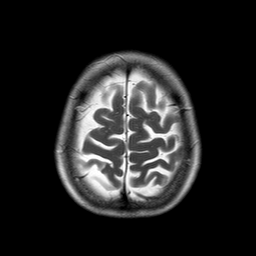

In [ ]:
series_instance_uid = '1.3.46.670589.11.10042.5.0.6840.2023122400165489007' # @param {type:"string"}
slice_index = 15 # @param {type:"integer"}

study_path = DATA_DIR / series_instance_uid
series = read_dicom_series(study_path)

series_array = series['array']

slice_array = series_array[slice_index]
slice_header = series['headers'][slice_index]
windowed_slice_array = apply_windowing_using_header(slice_array, slice_header)

Image.fromarray((windowed_slice_array * 255).astype('uint8'))

Examine shapes of raw data:

In [ ]:
study_paths = [i for i in DATA_DIR.iterdir() if i.is_dir() and len(list(i.glob('*.dcm'))) > 0]

shapes = list()
for p in study_paths:
    series = read_dicom_series(p)
    shapes.append(series['array'].shape)

print(set(shapes))

{(16, 288, 288), (20, 256, 256), (18, 288, 288), (18, 256, 256), (20, 288, 288), (16, 256, 256), (16, 320, 320), (20, 384, 384)}


Split to training/validation sub-sets:

In [ ]:
from sklearn.model_selection import train_test_split


validation_size = 0.3

stratify_df = annotations['prediction']
training_df, validation_df = train_test_split(
    annotations,
    test_size=validation_size,
    stratify=annotations['prediction'],
    random_state=7
)

We will clip all Dicom series to have 16 slices and resize to (256, 256), i.e. the final prepared data shape will be (16, 256, 256):

#### original :

In [ ]:
import tensorflow as tf
from tqdm import tqdm


def prepare_data(df: pd.DataFrame, split: str, target_h: int, target_w: int, expected_num_slices: int):
    prepared_data_dir_for_split = PREPARED_DATA_DIR / split
    prepared_data_dir_for_split.mkdir(parents=True, exist_ok=True)
    prepared_data_paths = list()

    for ind, row in tqdm(df.iterrows()):
        siuid = row['SeriesInstanceUID']
        study_path = DATA_DIR / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])



        # for a in range(len(windowed_series)) :

        #   windowed_series[a] = brain_mri_augmentation_kryptonite_version(image=windowed_series[a])





        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))

        else:
            arr = windowed_series


        if len(arr) != 16:
            remainder = len(arr) - 16
            arr = arr[int(remainder / 2): 16 + int(remainder / 2)]


        prepared_path = prepared_data_dir_for_split / f'{siuid}.npy'
        with open(prepared_path, 'wb') as f:
            np.save(f, arr)
        prepared_data_paths.append(prepared_path)

    df['prepared_path'] = prepared_data_paths


expected_num_slices = 16
target_h = 256
target_w = 256

prepare_data(training_df, 'training', target_h, target_w, expected_num_slices)
prepare_data(validation_df, 'validation', target_h, target_w, expected_num_slices)

19it [00:08,  2.74it/s]

## damain chat :

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd

# Assuming you have this augmentation function already defined
# def brain_mri_augmentation_kryptonite_version(image): ...

def prepare_data(df: pd.DataFrame, split: str, target_h: int, target_w: int, expected_num_slices: int):
    prepared_data_dir_for_split = PREPARED_DATA_DIR / split
    prepared_data_dir_for_split.mkdir(parents=True, exist_ok=True)
    prepared_data_paths = list()

    for ind, row in tqdm(df.iterrows()):
        siuid = row['SeriesInstanceUID']
        study_path = DATA_DIR / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])

        # Apply augmentation to each slice in the series
        for a in range(len(windowed_series)):
            img_array = windowed_series[a]

            # Ensure the image is in uint8 format before applying augmentation
            if img_array.dtype == np.float32 or img_array.dtype == np.float64:
                img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)

            # Apply the augmentation to the slice
            augmented_data = brain_mri_augmentation_kryptonite_version(image=img_array)

            # Assuming the augmented image is stored in a specific key in the returned dictionary
            augmented_img = augmented_data['image']  # Adjust this key according to the structure of the returned dict

            # Ensure augmented_img has 3 dimensions by adding a channel dimension if necessary
            if augmented_img.ndim == 2:
                augmented_img = np.expand_dims(augmented_img, axis=-1)  # Add channel dimension

            # Resize the augmented image to match the original dimensions of the slice (e.g., 288x288)
            if augmented_img.shape[:2] != windowed_series[a].shape[:2]:
                augmented_img = tf.image.resize(augmented_img, (windowed_series[a].shape[0], windowed_series[a].shape[1]))
                augmented_img = augmented_img.numpy()  # Convert back to NumPy array after resizing

            # Remove the channel dimension if the original image was 2D
            if windowed_series[a].ndim == 2:
                augmented_img = np.squeeze(augmented_img, axis=-1)

            windowed_series[a] = augmented_img  # Replace the original slice with the augmented one

        # Resize the slices if necessary
        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))
        else:
            arr = windowed_series

        # Ensure that the number of slices is exactly 16
        if len(arr) != expected_num_slices:
            remainder = len(arr) - expected_num_slices
            arr = arr[int(remainder / 2): expected_num_slices + int(remainder / 2)]

        # Save the prepared array
        prepared_path = prepared_data_dir_for_split / f'{siuid}.npy'
        with open(prepared_path, 'wb') as f:
            np.save(f, arr)
        prepared_data_paths.append(prepared_path)

    # Store the prepared file paths in the DataFrame
    df['prepared_path'] = prepared_data_paths

# Example usage:
expected_num_slices = 16
target_h = 256
target_w = 256

prepare_data(training_df, 'training', target_h, target_w, expected_num_slices)
prepare_data(validation_df, 'validation', target_h, target_w, expected_num_slices)


63it [00:42,  1.50it/s]
27it [00:18,  1.50it/s]


Create datasets:

In [ ]:
def read_npy_file(item):
    data = np.load(item.decode())
    return np.expand_dims(data.astype(np.float32), axis=-1)


def create_ds(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    paths = [str(i) for i in df['prepared_path']]
    volumes = tf.data.Dataset.from_tensor_slices(paths).map(lambda item: tf.numpy_function(read_npy_file, [item], [tf.float32,])[0])
    labels = tf.data.Dataset.from_tensor_slices(df['prediction'].values)
    zipped = tf.data.Dataset.zip(volumes, labels)

    # 67 16 256 256 1

    ds = zipped.shuffle(len(paths), seed=7).batch(batch_size).repeat()
    return ds


BATCH_SIZE = 4

training_ds = create_ds(training_df, BATCH_SIZE)
n_iter_training = (len(training_df) // BATCH_SIZE) + int((len(training_df) % BATCH_SIZE) > 0)
validation_ds = create_ds(validation_df, BATCH_SIZE)
n_iter_validation = (len(validation_df) // BATCH_SIZE) + int((len(validation_df) % BATCH_SIZE) > 0)

tr_gen = training_ds.as_numpy_iterator()
val_gen = validation_ds.as_numpy_iterator()

Visualize the dataset:

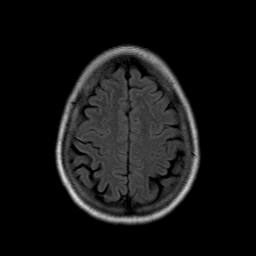

In [ ]:
xb, yb = next(tr_gen)

batch_ind = 0
slice_ind = 13
Image.fromarray((xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8'))

# Elena : preprocessing

### Batcode

In [ ]:
import albumentations as A
height=256
width=256

brain_mri_augmentation_kryptonite_version = A.Compose([

        # Mild noise
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.6),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.6)
        ], p=0.6),


        # Blurring, but not too strong
        A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.7, 1.2), p=0.7),

        # Random rotation and flipping
        A.Rotate(limit=(-15, 15), p=0.7),  #  rotation within safe limits
        A.HorizontalFlip(p=0.5),

        # Random cropping to add spatial variance
        A.RandomResizedCrop(height=height, width=width, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.6),

        A.ElasticTransform(alpha=1.0, sigma=50, alpha_affine=None, p=0.5),

        A.GridDistortion(num_steps=4, distort_limit=0.2, p=0.5),

        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),

        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),

        A.Resize(height=height, width=width, p=1)
    ], p=1)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


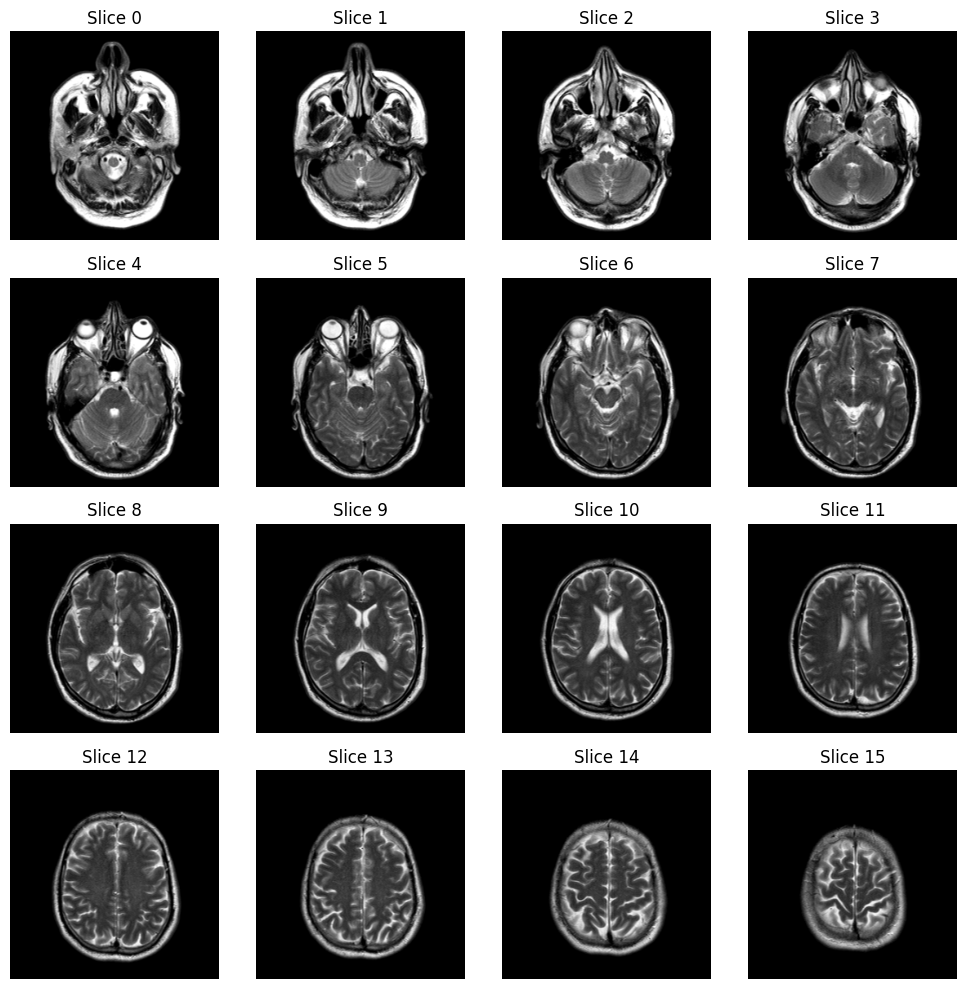

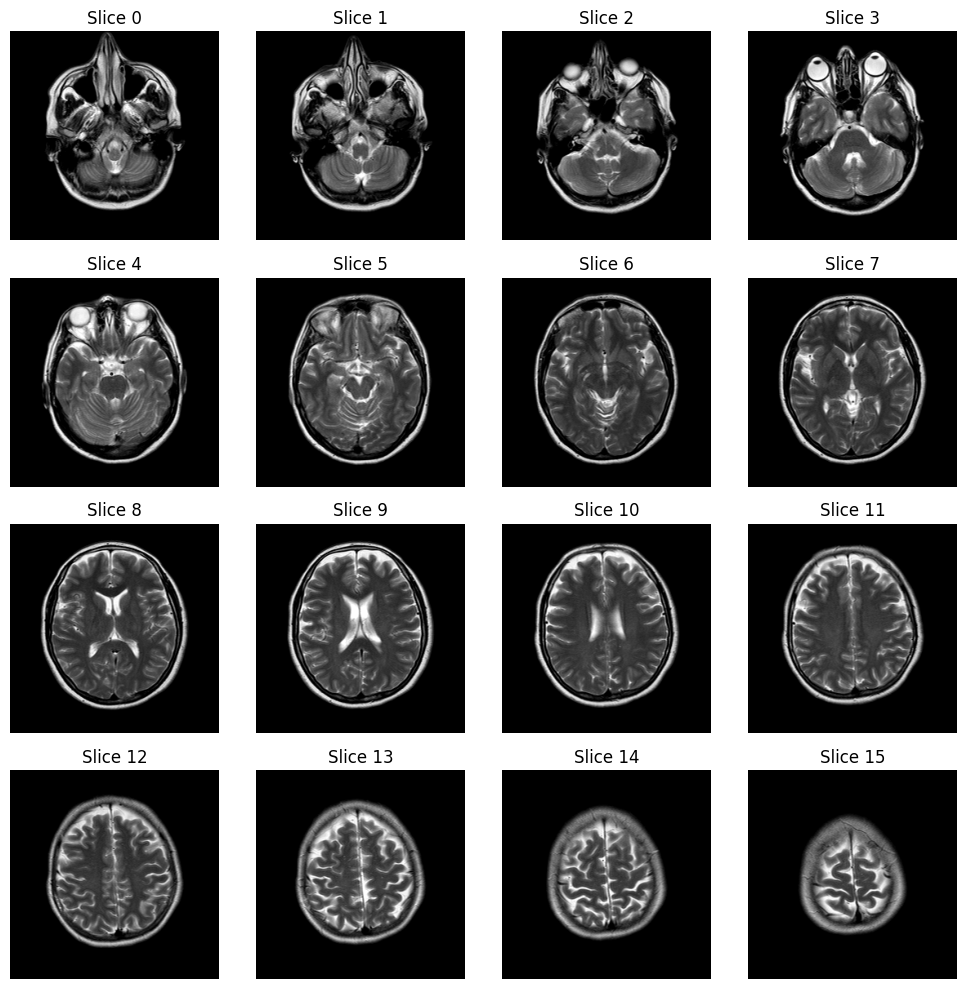

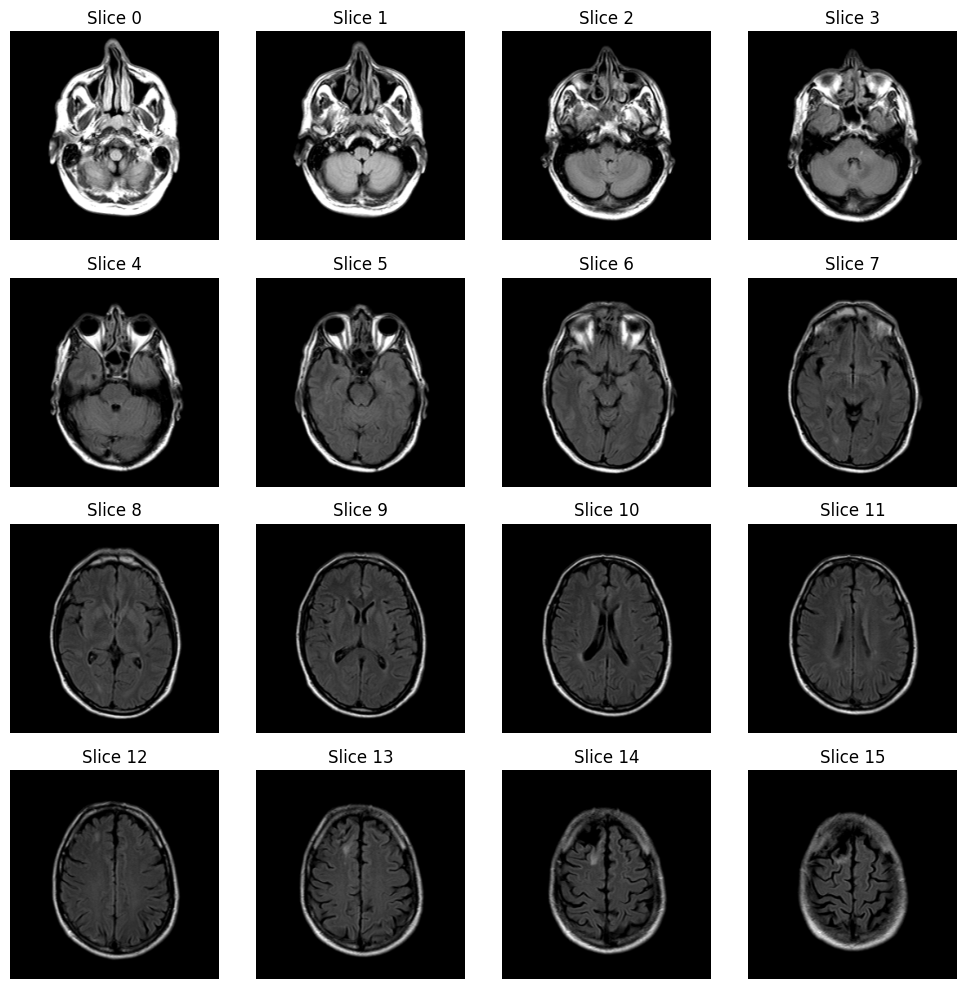

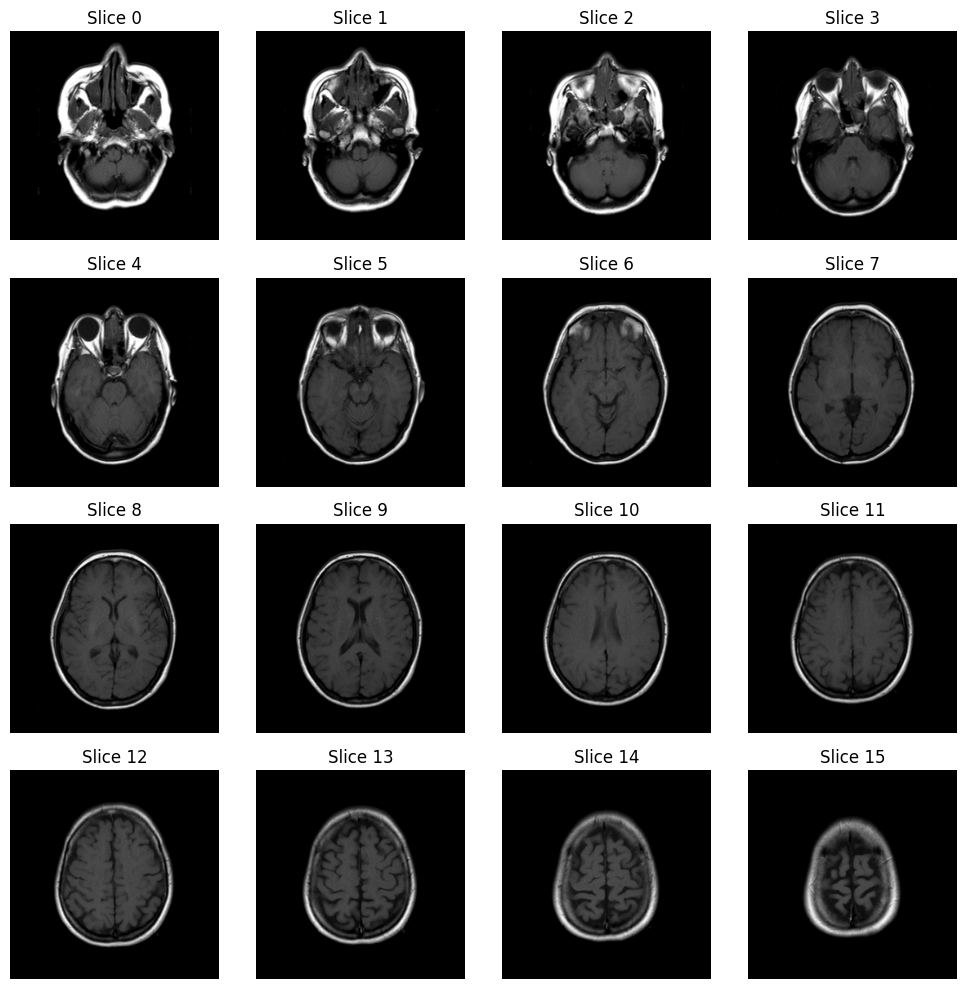

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming tr_gen is a generator or iterable that provides batches
xb, yb = next(tr_gen)

# Parameters for displaying images in a grid (4 images per row)
images_per_row = 4
fig_size = (10, 10)  # Adjust the figure size

# Loop over batch indices and slice indices to convert and display images
for batch_ind in range(xb.shape[0]):  # Iterate over batches
    total_slices = xb.shape[1]

    # Create a figure with subplots
    fig, axes = plt.subplots((total_slices + images_per_row - 1) // images_per_row, images_per_row, figsize=fig_size)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for slice_ind in range(total_slices):  # Iterate over slices within each batch
        # Extract and rescale the image slice, assuming it's normalized
        img_array = (xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8')

        # Create an image object from the array
        img = Image.fromarray(img_array)

        # Display the image in the appropriate subplot
        axes[slice_ind].imshow(img, cmap='gray')
        axes[slice_ind].set_title(f'Slice {slice_ind}')
        axes[slice_ind].axis('off')  # Turn off the axis for cleaner display

    # Hide any remaining empty subplots
    for ax in axes[total_slices:]:
        ax.axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install torchio

In [ ]:
import torchio as tio

# Reshape to (1, 256, 256, 1)
image_reshaped = np.expand_dims(img_array, axis=0)  # Adds the channel dimension
subject = np.expand_dims(image_reshaped, axis=-1)  # Adds the z-axis dimension


affine_transforms = {
    tio.RandomAffine(degrees = 15, translation = 5) : 0.9,
    tio.RandomFlip(axes=['LR']) : 0.7
}

pixel_wise_transforms = {
    tio.RandomBlur() : 0.9,
}

Elastic_transforms = {
    tio.RandomElasticDeformation(num_control_points = 4,             # pouya : elena this was the num of control points that u needed to change.
                                                                        # also i dont think this transformation is going to help in this casse ,
                                                                          # please read the document to see what it exactly does and then lets talk about it
                                                                            # link : https://torchio.readthedocs.io/transforms/augmentation.html#randomelasticdeformation
                                 locked_borders =1 ) :0.2,
}

transform = tio.Compose([
    tio.OneOf(pixel_wise_transforms, p=0.9),
    tio.OneOf(affine_transforms, p=0.75),
    tio.OneOf(Elastic_transforms, p=0.3),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])


transformed = transform(subject)


/usr/local/lib/python3.10/dist-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


In [ ]:
import numpy as np
import torchio as tio


# Reshape to (1, 256, 256, 1)
image_reshaped = np.expand_dims(img_array, axis=0)  # Adds the channel dimension
subject = np.expand_dims(image_reshaped, axis=-1)  # Adds the z-axis dimension

# Create a TorchIO subject from the numpy array
subject = tio.Subject(image=tio.ScalarImage(tensor=subject))

# Define the transforms
affine_transforms = [
    tio.RandomAffine(degrees=15, translation=5),
    tio.RandomFlip(axes=['LR'])
]

pixel_wise_transforms = [
    tio.RandomBlur()
]

elastic_transforms = [
    tio.RandomElasticDeformation(num_control_points=5, locked_borders=2),
]

# Define the probabilities
probabilities = {
    'affine': 0.75,
    'pixel_wise': 0.9,
    'elastic': 0.3,
}

# Improved transform function
transform1 = tio.Compose([
    tio.OneOf(pixel_wise_transforms, p=probabilities['pixel_wise']),
    tio.OneOf(affine_transforms, p=probabilities['affine']),
    tio.OneOf(elastic_transforms, p=probabilities['elastic']),
    tio.RescaleIntensity(out_min_max=(0, 1)),
])

# Apply the transform to the subject
transformed_subject = transform1(subject)

# Access the transformed image
transformed_image = transformed_subject['image'].tensor.numpy()

print("Transformed image shape:", transformed_image.shape)


Transformed image shape: (1, 256, 256, 1)


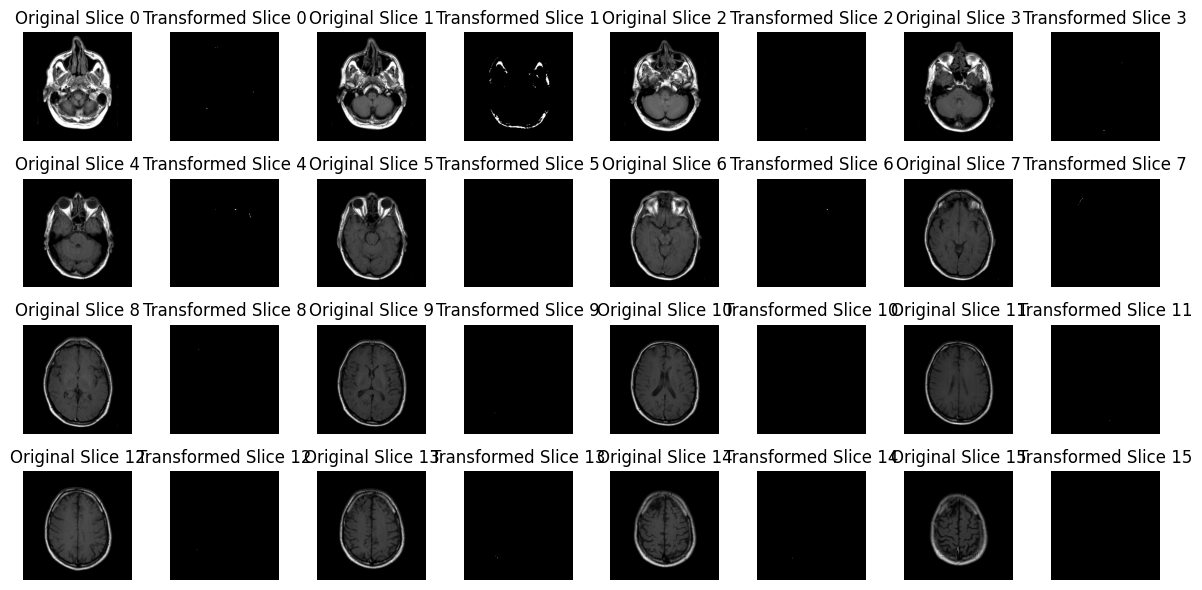

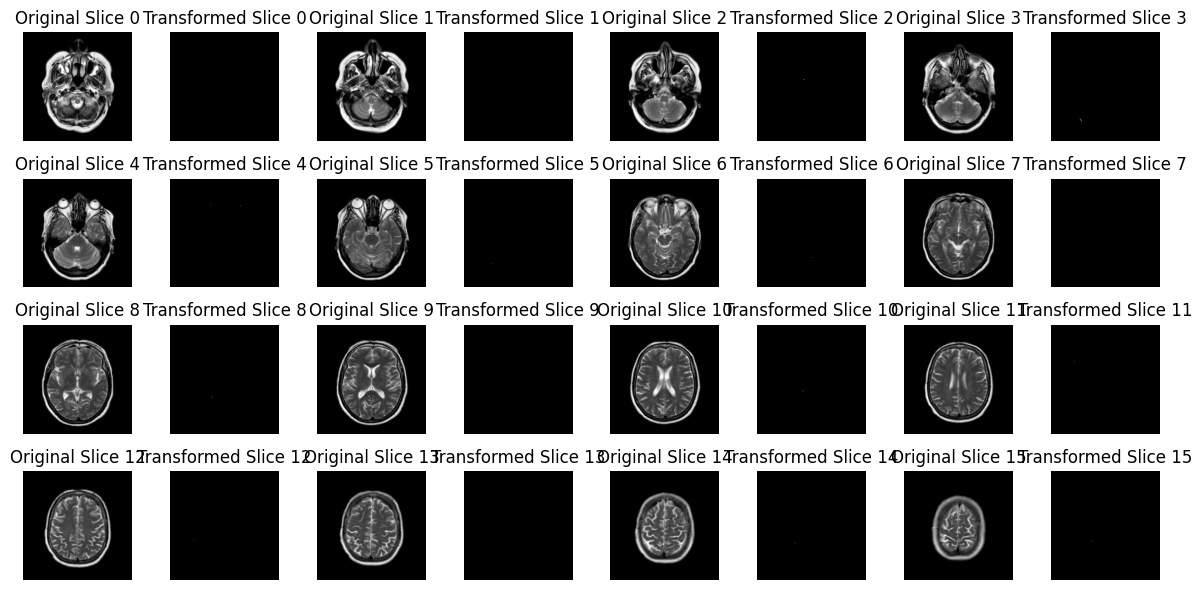

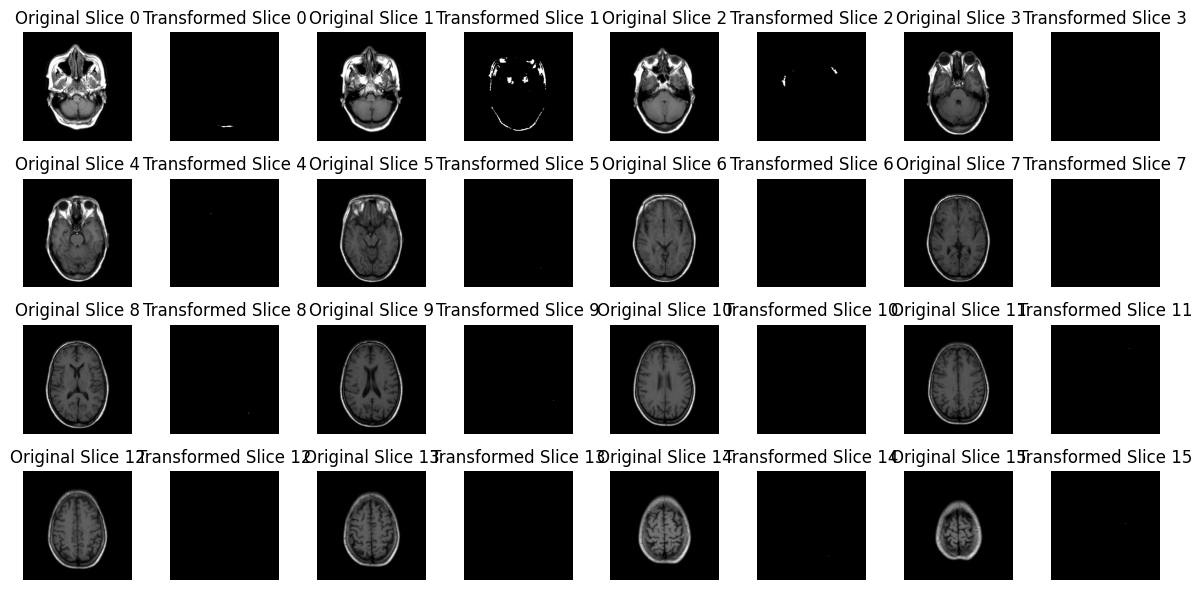

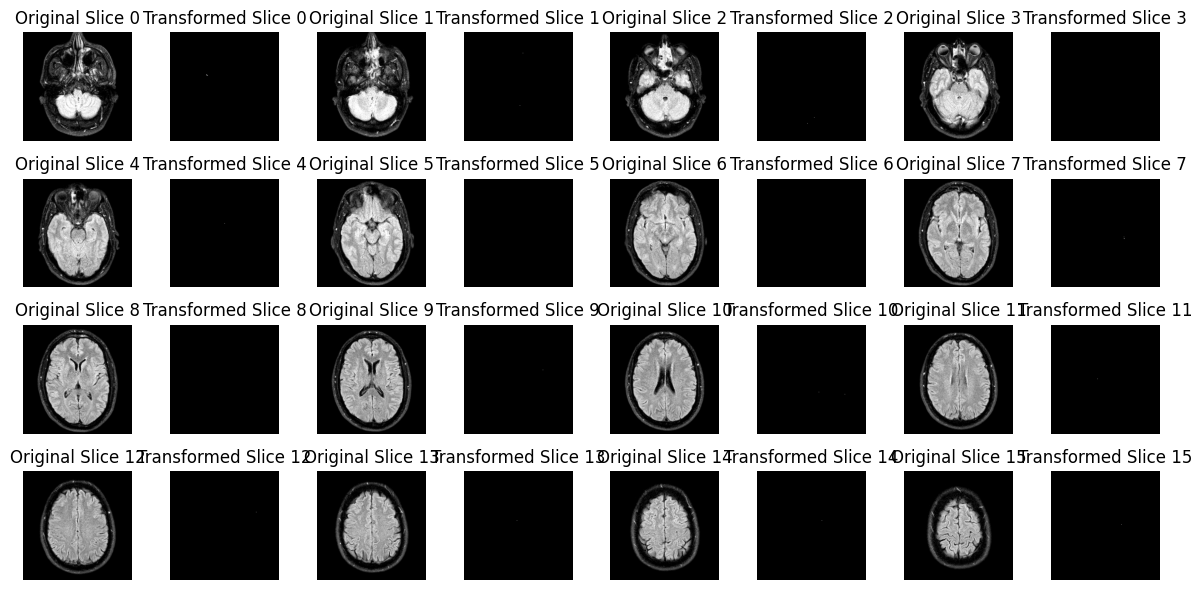

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming tr_gen is a generator or iterable that provides batches
xb, yb = next(tr_gen)

# Parameters for displaying images in a grid (4 image pairs per row)
images_per_row = 4
fig_size = (12, 6)  # Adjust the figure size

# Loop over batch indices and slice indices to convert and display images
for batch_ind in range(xb.shape[0]):  # Iterate over batches
    total_slices = xb.shape[1]

    # Create a figure with subplots (2 columns for each original/transformed pair)
    fig, axes = plt.subplots((total_slices + images_per_row - 1) // images_per_row, images_per_row * 2, figsize=fig_size)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for slice_ind in range(total_slices):  # Iterate over slices within each batch
        # Extract and rescale the original image slice, assuming it's normalized
        original_img_array = (xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8')
        original_img = Image.fromarray(original_img_array)

        # Perform the transformation on the image
        image_reshaped = np.expand_dims(original_img_array, axis=(0, -1))  # Shape (1, 256, 256, 1)
        transformed = transform1(image_reshaped)  # Apply your transform function
        transformed = np.squeeze(transformed)  # Remove extra dimensions
        transformed_img = Image.fromarray(transformed.astype('uint8'))

        # Display the original image
        axes[slice_ind * 2].imshow(original_img, cmap='gray')
        axes[slice_ind * 2].set_title(f'Original Slice {slice_ind}')
        axes[slice_ind * 2].axis('off')

        # Display the transformed image
        axes[slice_ind * 2 + 1].imshow(transformed_img, cmap='gray')
        axes[slice_ind * 2 + 1].set_title(f'Transformed Slice {slice_ind}')
        axes[slice_ind * 2 + 1].axis('off')

        # Draw a line between the two images
        if slice_ind % images_per_row != images_per_row - 1:
            fig.subplots_adjust(wspace=0.05)  # Adjust horizontal space between subplots
            axes[slice_ind * 2 + 1].axvline(x=0, color='black', linewidth=2)  # Vertical line

    # Hide any remaining empty subplots
    for ax in axes[total_slices * 2:]:
        ax.axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 12.5 MB/s eta 0:00:00


In [ ]:
f'the shape of the trasformed {np.shape(transformed)} the type of it : {type(transformed)} and the data type of it is {transformed.dtype}' # pouya : always check what you are dealing with :)


"the shape of the trasformed (1, 256, 256, 1) the type of it : <class 'numpy.ndarray'> and the data type of it is float32"

In [ ]:
transformed = np.squeeze(transformed) # pouya: we change the data to how it was before , so that we can use it.
f'the shape of the trasformed {np.shape(transformed)} the type of it : {type(transformed)} and the data type of it is {transformed.dtype}' # pouya : always check what you are dealing with :)

"the shape of the trasformed (256, 256) the type of it : <class 'numpy.ndarray'> and the data type of it is float32"

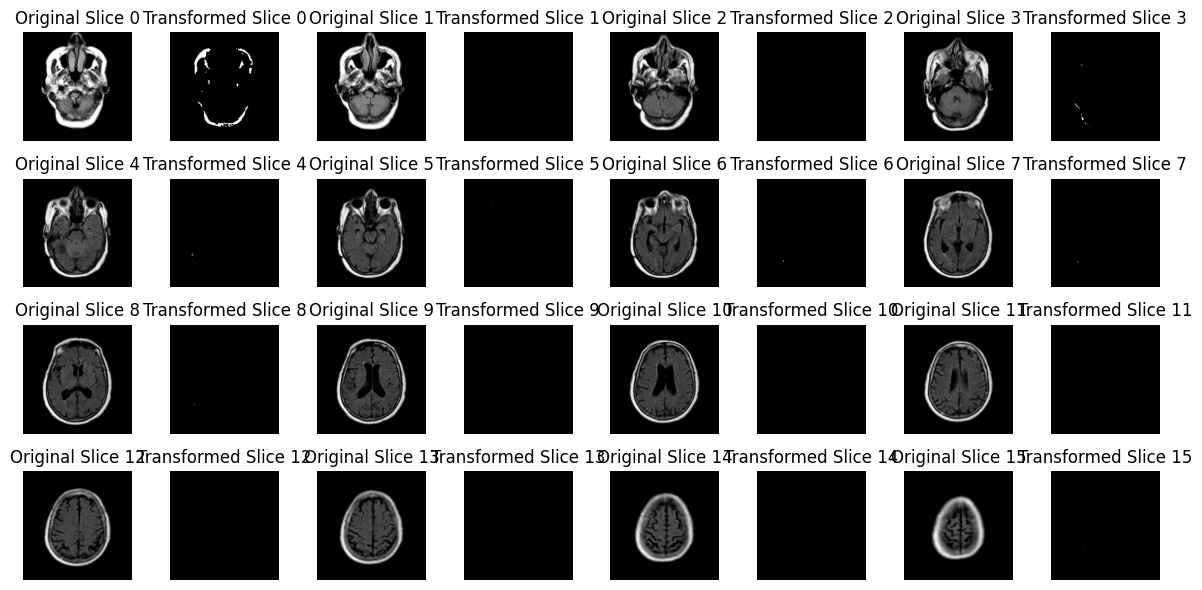

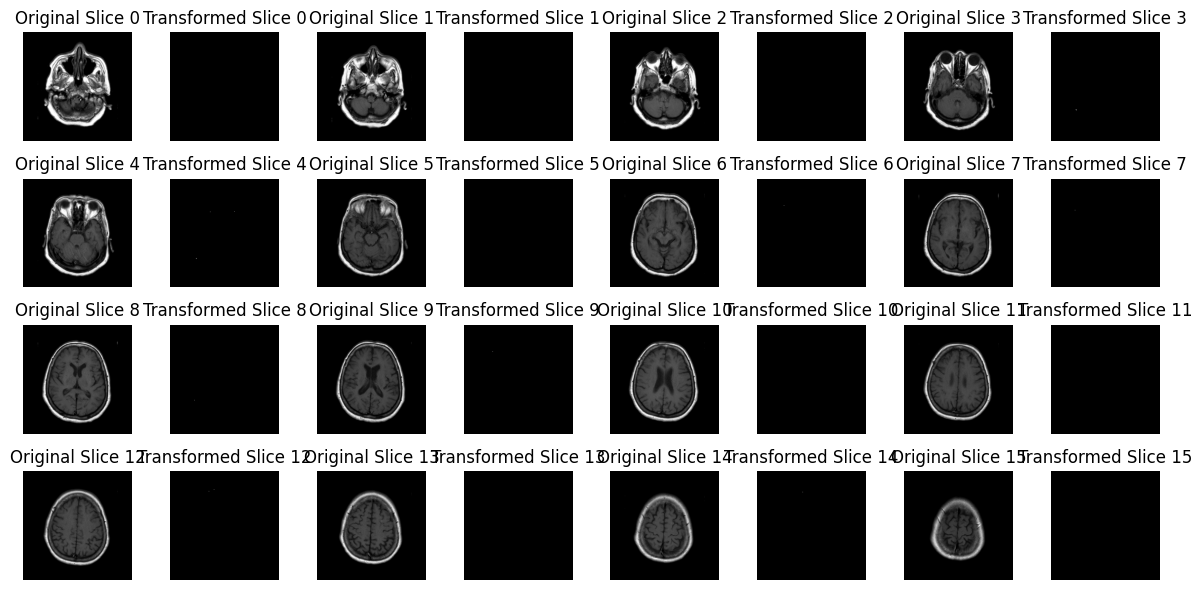

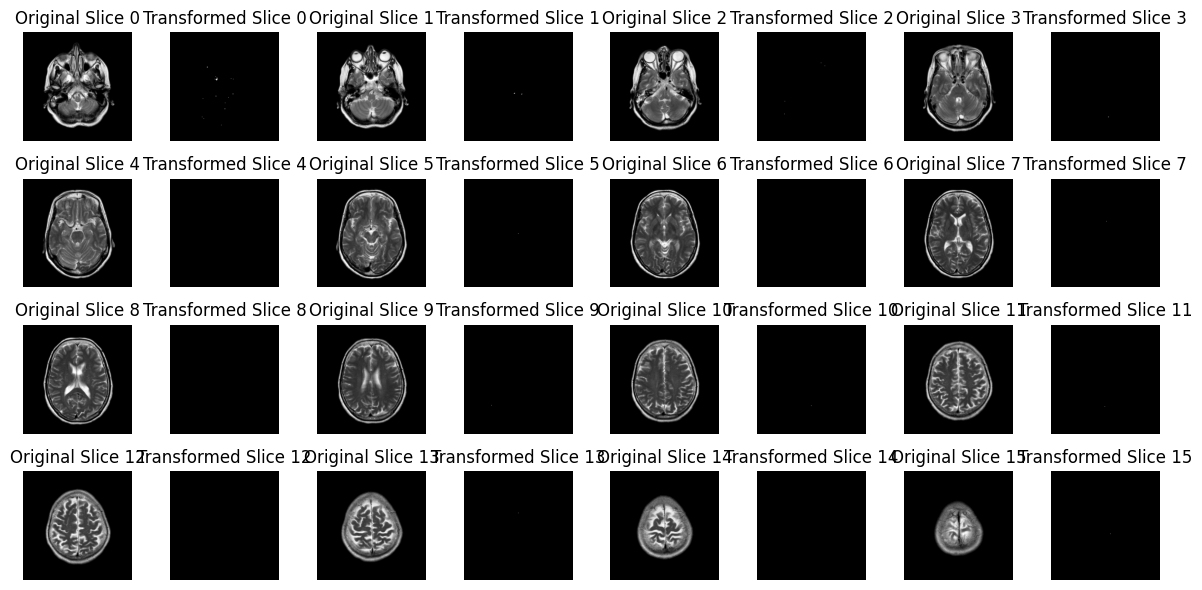

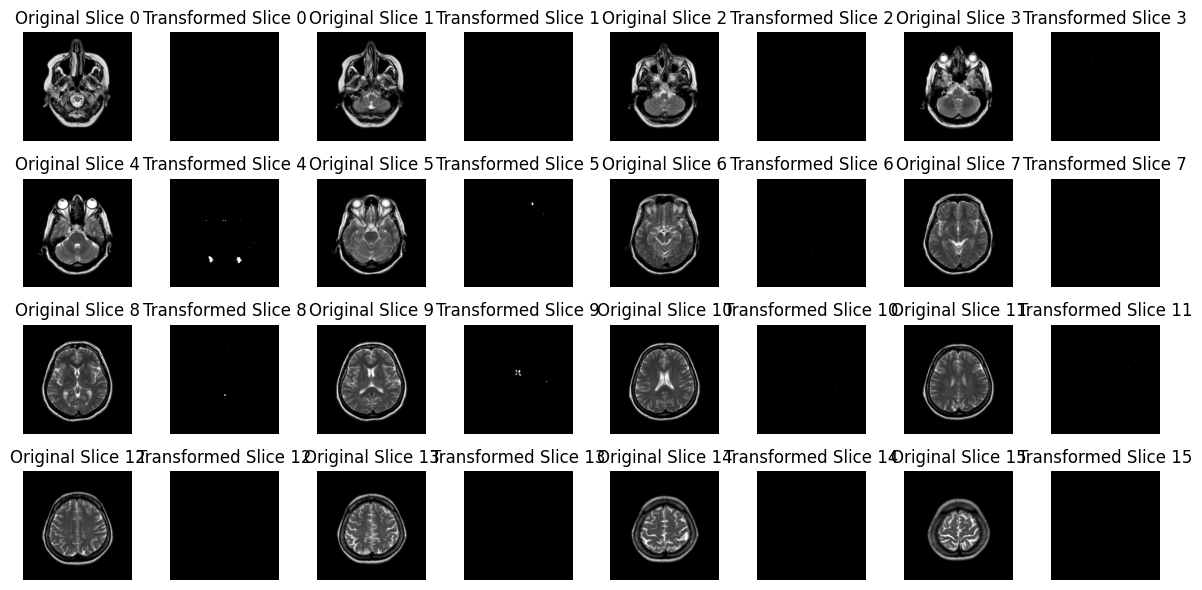

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming tr_gen is a generator or iterable that provides batches
xb, yb = next(tr_gen)

# Parameters for displaying images in a grid (4 image pairs per row)
images_per_row = 4
fig_size = (12, 6)  # Adjust the figure size

# Loop over batch indices and slice indices to convert and display images
for batch_ind in range(xb.shape[0]):  # Iterate over batches
    total_slices = xb.shape[1]

    # Create a figure with subplots (2 columns for each original/transformed pair)
    fig, axes = plt.subplots((total_slices + images_per_row - 1) // images_per_row, images_per_row * 2, figsize=fig_size)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for slice_ind in range(total_slices):  # Iterate over slices within each batch
        # Extract and rescale the original image slice, assuming it's normalized
        original_img_array = (xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8')
        original_img = Image.fromarray(original_img_array)

        # Perform the transformation on the image
        image_reshaped = np.expand_dims(original_img_array, axis=(0, -1))  # Shape (1, 256, 256, 1)
        transformed = transform(image_reshaped)  # Apply your transform function
        transformed = np.squeeze(transformed)  # Remove extra dimensions
        transformed_img = Image.fromarray(transformed.astype('uint8'))

        # Display the original image
        axes[slice_ind * 2].imshow(original_img, cmap='gray')
        axes[slice_ind * 2].set_title(f'Original Slice {slice_ind}')
        axes[slice_ind * 2].axis('off')

        # Display the transformed image
        axes[slice_ind * 2 + 1].imshow(transformed_img, cmap='gray')
        axes[slice_ind * 2 + 1].set_title(f'Transformed Slice {slice_ind}')
        axes[slice_ind * 2 + 1].axis('off')

        # Draw a line between the two images
        if slice_ind % images_per_row != images_per_row - 1:
            fig.subplots_adjust(wspace=0.05)  # Adjust horizontal space between subplots
            axes[slice_ind * 2 + 1].axvline(x=0, color='black', linewidth=2)  # Vertical line

    # Hide any remaining empty subplots
    for ax in axes[total_slices * 2:]:
        ax.axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()


In [ ]:
import albumentations as A

p1 = 1
p3 = 0.8
transform = A.Compose([
    A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.5, 1.0), p=0.8),
    A.OneOf([
        A.RandomCropFromBorders(crop_value=(0.02, 0.05), p=0.6),
        A.Rotate(limit=(-10, 10), p=0.5),
        A.ShiftScaleRotate(shift_limit=(-0.03, 0.03),
                           scale_limit=(-0.05, 0.05),
                           rotate_limit=0,
                           p=0.4)
    ], p=p3)
], p=p1)

transformed = transform(image=?)

transformed_image = transformed["image"] ?

/usr/local/lib/python3.10/dist-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


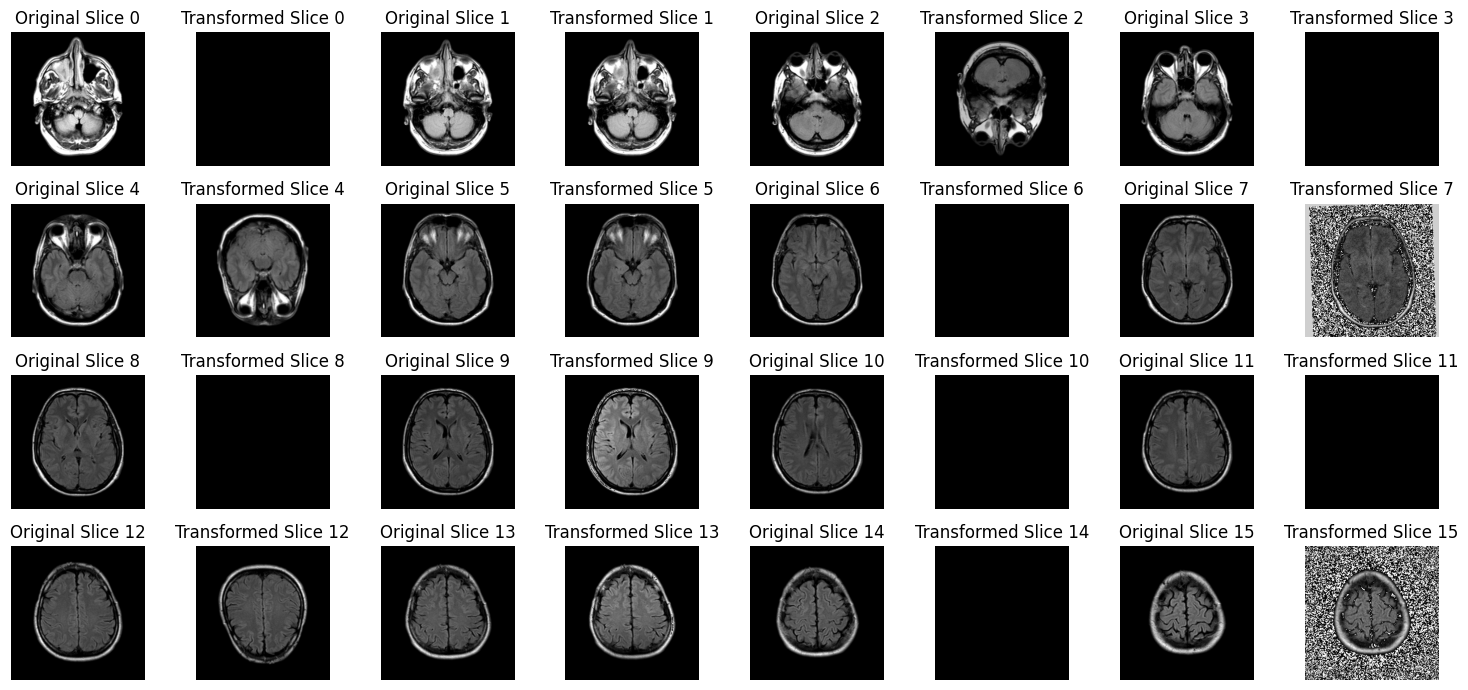

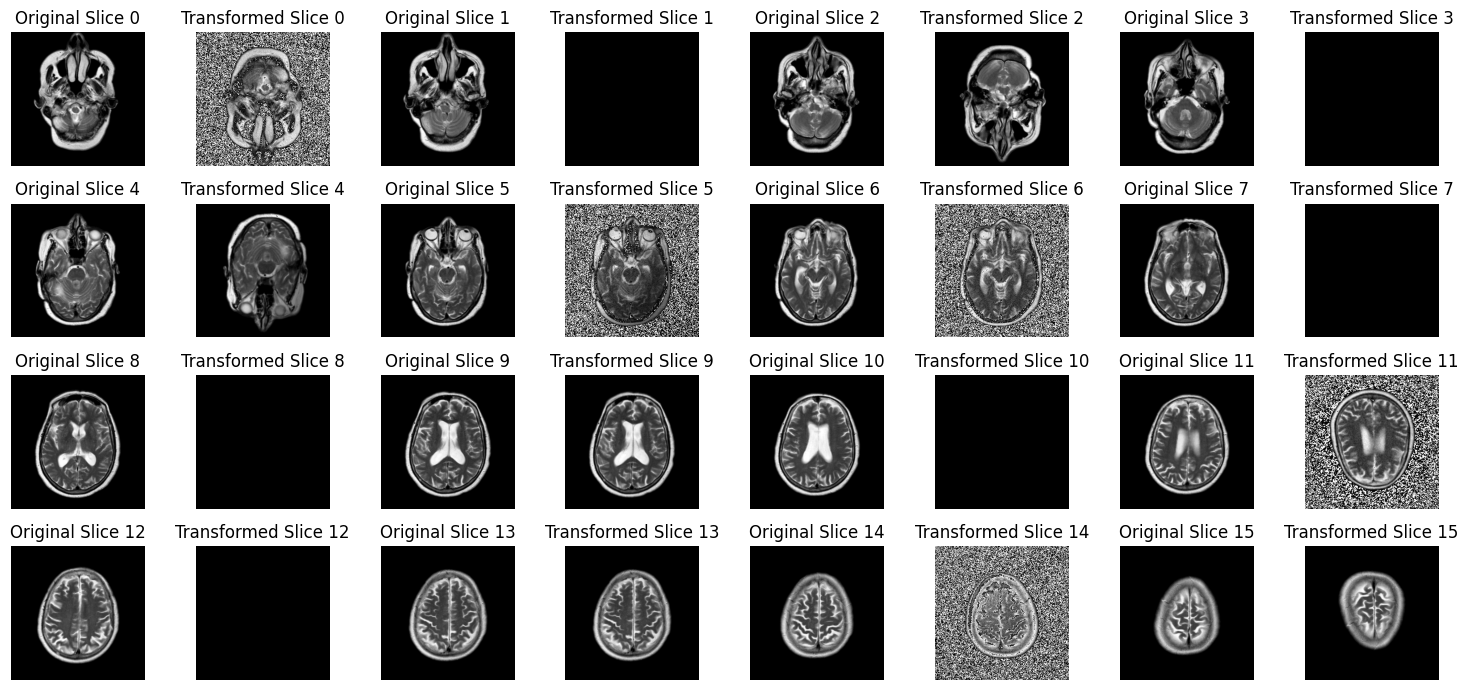

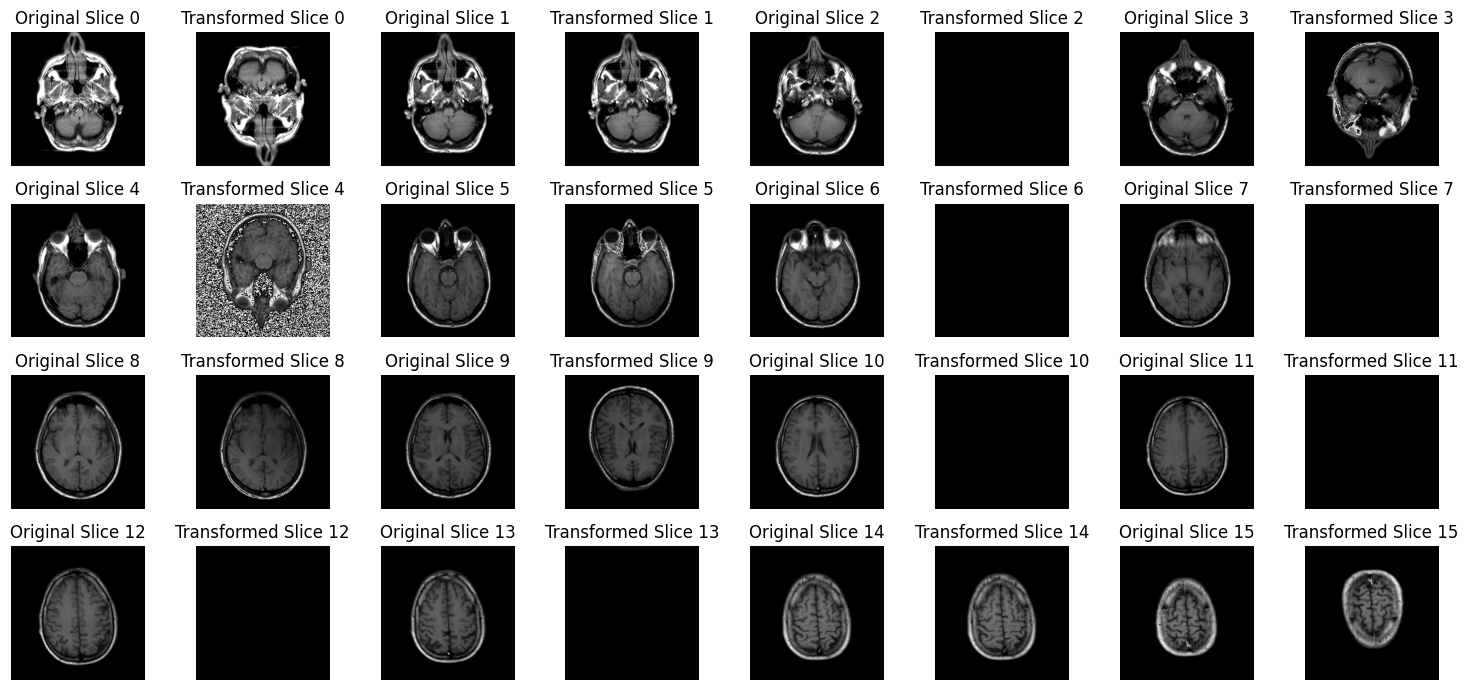

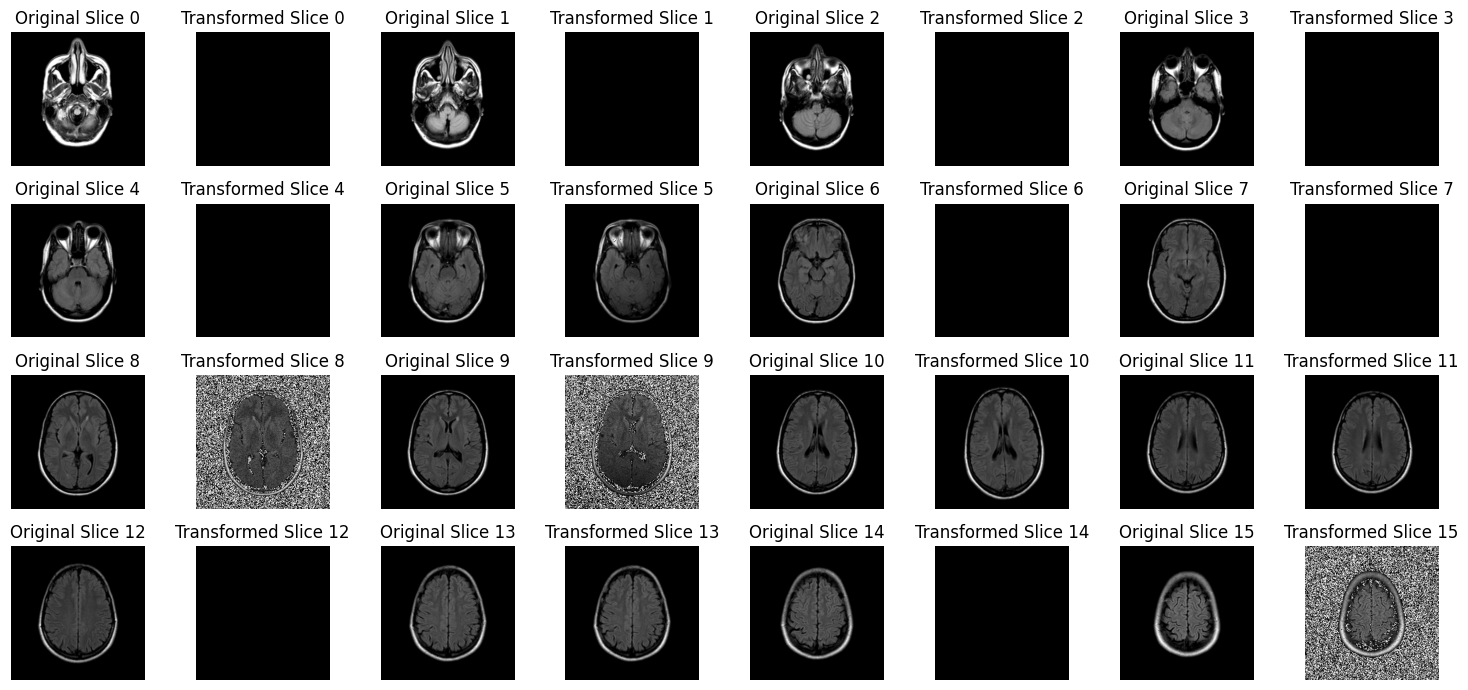

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchio as tio

# Assuming tr_gen is a generator or iterable that provides batches
xb, yb = next(tr_gen)

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomNoise(mean=0, std=0.05, p=0.3),
    tio.RandomBiasField(coefficients=0.5, p=0.3),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=5, translation=5, p=0.5),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=3, p=0.3),
    tio.RandomFlip(axes=(0, 1), p=0.5)
])

# Parameters for displaying images in a grid (2 images per slice: original + transformed)
images_per_row = 4
fig_size = (15, 7)  # Adjust the figure size

# Loop over batch indices and slice indices to convert and display images
for batch_ind in range(xb.shape[0]):  # Iterate over batches
    total_slices = xb.shape[1]

    # Create a figure with subplots (2 images per slice: original + transformed)
    fig, axes = plt.subplots((total_slices + images_per_row - 1) // images_per_row,
                             images_per_row * 2, figsize=fig_size)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for slice_ind in range(total_slices):  # Iterate over slices within each batch
        # Extract and rescale the original image slice
        img_array = (xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8')
        original_img = Image.fromarray(img_array)


        subject = tio.Subject(
            mri=tio.ScalarImage(tensor=np.expand_dims(img_array, axis=(0, -1)))
        )


        transformed_subject = transform(subject)
        transformed_img_array = transformed_subject['mri'].numpy().squeeze()
        transformed_img = Image.fromarray((transformed_img_array * 255).astype('uint8'))

        # Display the original image
        axes[slice_ind * 2].imshow(original_img, cmap='gray')
        axes[slice_ind * 2].set_title(f'Original Slice {slice_ind}')
        axes[slice_ind * 2].axis('off')

        # Display the transformed image
        axes[slice_ind * 2 + 1].imshow(transformed_img, cmap='gray')
        axes[slice_ind * 2 + 1].set_title(f'Transformed Slice {slice_ind}')
        axes[slice_ind * 2 + 1].axis('off')

    # Hide any remaining empty subplots
    for ax in axes[total_slices * 2:]:
        ax.axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()


# Prepare Model

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras


def create_model(expected_num_slices: int, target_h: int, target_w: int) -> keras.Model:
    inputs = keras.Input((expected_num_slices, target_h, target_w, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model


expected_num_slices = 16
target_h = 256
target_w = 256

model = create_model(expected_num_slices, target_h, target_w)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 16, 256, 256, 64   1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 128, 128, 64)   0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 8, 128, 128, 64)   256       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 128, 128, 64)   110656

# pouya : defining a better model for running on T4

## model 1 : just some modifications

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

def create_model(expected_num_slices: int, target_h: int, target_w: int) -> keras.Model:
    inputs = keras.Input((expected_num_slices, target_h, target_w, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

expected_num_slices = 16
target_h = 256
target_w = 256

model = create_model(expected_num_slices, target_h, target_w)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 16, 256, 256, 32   896       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 128, 128, 32)   0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 8, 128, 128, 32)   128       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 128, 128, 64)   55360 

## model 2 : lets increace the parameters and see what happends

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

def create_model(expected_num_slices: int, target_h: int, target_w: int) -> keras.Model:
    inputs = keras.Input((expected_num_slices, target_h, target_w, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

expected_num_slices = 16
target_h = 256
target_w = 256

model = create_model(expected_num_slices, target_h, target_w)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 conv3d_4 (Conv3D)           (None, 16, 256, 256, 64   1792      
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 8, 128, 128, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 8, 128, 128, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 128, 128, 128   2213

## model 3: maybe resnet ?

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    # Shortcut path
    shortcut = x
    if x.shape[-1] != filters:  # Adjust shortcut if dimensions do not match
        shortcut = layers.Conv3D(filters=filters, kernel_size=1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual path
    x = layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adding the shortcut to the residual path
    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

def create_resnet_model(expected_num_slices: int, target_h: int, target_w: int) -> keras.Model:
    inputs = keras.Input((expected_num_slices, target_h, target_w, 1))

    # Initial Conv3D layer
    x = layers.Conv3D(filters=64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    return model

expected_num_slices = 16
target_h = 256
target_w = 256

model = create_resnet_model(expected_num_slices, target_h, target_w)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16, 256, 256, 1)]    0         []                            
                                                                                                  
 conv3d_15 (Conv3D)          (None, 16, 256, 256, 64)     22016     ['input_5[0][0]']             
                                                                                                  
 max_pooling3d_9 (MaxPoolin  (None, 8, 128, 128, 64)      0         ['conv3d_15[0][0]']           
 g3D)                                                                                             
                                                                                                  
 batch_normalization_21 (Ba  (None, 8, 128, 128, 64)      256       ['max_pooling3d_9[0][0]'

## tiny vgg ;))

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

def create_tiny_vgg_model(input_shape, hidden_units, output_units):
    inputs = keras.Input(input_shape)

    # First conv block
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    # Second conv block
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(output_units, activation='softmax')(x)

    model = keras.Model(inputs, x)
    return model

# Assuming you are using the same shape as the 3D model for MRI data
expected_num_slices = 16
target_h = 256
target_w = 256
input_shape = (expected_num_slices, target_h, target_w, 1)
hidden_units = 64
output_units = 1  # Adjust according to your output needs

model = create_tiny_vgg_model(input_shape, hidden_units, output_units)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc'),
    keras.metrics.BinaryAccuracy(name='accuracy')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 16, 256, 256, 64   1792      
                             )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 256, 256, 64   110656    
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 128, 128, 64)   0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 128, 128, 64)   110656

## efficient net

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

def create_efficientnetb0_model(input_shape, output_units):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(output_units, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Assuming a 2D adaptation for EfficientNetB0
input_shape = (256, 256, 3)  # Use a 2D input shape here
output_units = 1  # Adjust according to your output needs

model = create_efficientnetb0_model(input_shape, output_units)

metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 256, 256, 3)          0         ['input_35[0][0]']            
                                                                                                  
 normalization_2 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 256, 256, 3)          0         ['normalization_2[0][0]

## lets try resnet_50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

def create_resnet50_model(input_shape, output_units):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(output_units, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Assuming a 2D adaptation for ResNet50
input_shape = (256, 256, 3)  # Use a 2D input shape here
output_units = 1  # Adjust according to your output needs

model = create_resnet50_model(input_shape, output_units)

metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_32[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## vgg 16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Model

def create_vgg16_model(input_shape, output_units):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(output_units, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Assuming a 2D adaptation for VGG16
input_shape = (256, 256, 3)  # Use a 2D input shape here
output_units = 1  # Adjust according to your output needs

model = create_vgg16_model(input_shape, output_units)

metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet32
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model

def create_vgg16_model_with_pseudo_rgb(input_shape, output_units):
    # Create an input layer with 3D input shape
    inputs = Input(shape=input_shape)

    # Assuming input_shape is (slices, height, width, channels)
    # Reshape the input to use 3 consecutive slices as 3 channels for VGG16
    # The first dimension (slices) needs to be 3 for RGB-like input to VGG16
    reshaped_input = tf.concat([inputs[:, i, :, :, :] for i in range(3)], axis=-1)

    # Load the VGG16 model with ImageNet weights, without the top layer
    base_model = ResNet32(weights='imagenet', include_top=False, input_shape=(input_shape[1], input_shape[2], 3))

    # Pass the reshaped input through the VGG16 model
    x = base_model(reshaped_input)

    # Add custom layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(output_units, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=predictions)

    return model

# Define the 3D input shape: for instance, 16 slices of 256x256 with 1 channel (grayscale)
# But for VGG16, we'll use 3 consecutive slices as RGB channels
input_shape = (16, 256, 256, 1)  # 16 slices, height=256, width=256, and 1 grayscale channel
output_units = 1  # Adjust this as needed for your classification task

# Create the model
model = create_vgg16_model_with_pseudo_rgb(input_shape, output_units)

# Compile the model
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

# Print the summary
model.summary()


ImportError: cannot import name 'ResNet32' from 'tensorflow.keras.applications' (/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/applications/__init__.py)

## Trying medsam2 with tiny vgg

# shape change from 2d to 3d

In [ ]:
def read_npy_file(item):
    data = np.load(item.decode())
    # Take the central slice
    central_slice = data[7, :, :].astype(np.float32)
    # Expand from 1 channel to 3 channels by repeating the same slice
    central_slice_rgb = np.repeat(central_slice[..., np.newaxis], 3, axis=-1)
    return central_slice_rgb

def create_ds(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    paths = [str(i) for i in df['prepared_path']]
    volumes = tf.data.Dataset.from_tensor_slices(paths).map(lambda item: tf.numpy_function(read_npy_file, [item], [tf.float32,])[0])
    labels = tf.data.Dataset.from_tensor_slices(df['prediction'].values)
    zipped = tf.data.Dataset.zip(volumes, labels)
    ds = zipped.shuffle(len(paths), seed=7).batch(batch_size).repeat()
    return ds


BATCH_SIZE = 4

training_ds = create_ds(training_df, BATCH_SIZE)
n_iter_training = (len(training_df) // BATCH_SIZE) + int((len(training_df) % BATCH_SIZE) > 0)
validation_ds = create_ds(validation_df, BATCH_SIZE)
n_iter_validation = (len(validation_df) // BATCH_SIZE) + int((len(validation_df) % BATCH_SIZE) > 0)

tr_gen = training_ds.as_numpy_iterator()
val_gen = validation_ds.as_numpy_iterator()


In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.applications as apps

def create_resnet50_model(input_shape, output_units):
    # Load pre-trained ResNet-50 model without the top classification layer
    base_model = apps.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model (optional, only for fine-tuning purposes)
    base_model.trainable = True

    # Create the new classification head
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Global Average Pooling to reduce the dimensionality
    x = layers.GlobalAveragePooling2D()(x)

    # Add fully connected layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer for binary classification (sigmoid for binary)
    outputs = layers.Dense(output_units, activation='sigmoid')(x)

    # Create the final model
    model = keras.Model(inputs, outputs)

    return model

# Set the shape based on the MRI data: (height, width, channels)
expected_num_slices = 16  # Keep in mind, ResNet expects 2D data, so each slice can be treated as an image
target_h = 256
target_w = 256
input_shape = (target_h, target_w, 3)  # ResNet expects 3 channels (RGB), so you can replicate the grayscale channel 3 times

output_units = 1  # Binary classification

# Create the ResNet50 model
model = create_resnet50_model(input_shape, output_units)

# Compile the model
metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

# Print the model summary
model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 513       
                                                          

### this is elon mask

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class GrayscaleToRGBLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(GrayscaleToRGBLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Convert grayscale to RGB
        return tf.image.grayscale_to_rgb(inputs)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def create_resnet50_tiny_vgg_model(input_shape, hidden_units, output_units):
    # Load pre-trained ResNet-50 model without the top classification layer
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[1], input_shape[2], 3))

    # Freeze the base model
    base_model.trainable = False

    # Define the input layer
    inputs = layers.Input(shape=input_shape)

    # Convert grayscale images to RGB
    rgb_images = GrayscaleToRGBLayer()(inputs)

    # Apply ResNet-50 to each slice
    x = layers.TimeDistributed(layers.Lambda(lambda slice: base_model(slice, training=False)))(rgb_images)

    # Add 3D convolutional layers
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(filters=hidden_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    # Flatten and add dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(output_units, activation='sigmoid')(x)

    # Create the final model
    model = models.Model(inputs, outputs)

    return model

# Set shape for input data
expected_num_slices = 16
target_h = 256
target_w = 256
input_shape = (expected_num_slices, target_h, target_w, 1)  # Grayscale images

hidden_units = 64
output_units = 1  # Binary classification

# Create the combined model
model = create_resnet50_tiny_vgg_model(input_shape, hidden_units, output_units)

# Compile the model
metrics = [
    tf.keras.metrics.SensitivityAtSpecificity(0.95),
    tf.keras.metrics.SpecificityAtSensitivity(0.95),
    tf.keras.metrics.AUC(name='auc')
]
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

# Print the model summary
model.summary()


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_0_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>
  <tf.Variable 'conv2_block1_0_conv/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_0_bn/gamma:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_0_bn/beta:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/kernel:0' shape=(1, 1, 64, 64) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_2_conv/kernel:0' s

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 grayscale_to_rgb_layer (Gr  (None, 16, 256, 256, 3)   0         
 ayscaleToRGBLayer)                                              
                                                                 
 time_distributed (TimeDist  (None, 16, 8, 8, 2048)    0         
 ributed)                                                        
                                                                 
 conv3d_4 (Conv3D)           (None, 16, 8, 8, 64)      3539008   
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 8, 8, 64)      110656    
                                                           

# Training

## applying the transformations

### using tensoreflow as an alternetive

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

def read_npy_file(item):
    data = np.load(item.decode())
    return np.expand_dims(data.astype(np.float32), axis=-1)

def apply_transformations(image, label):
    # Rescale intensity (normalize to range [0, 1])
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

    # Add random noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise

    # Random bias field
    bias = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=0.5)
    image = image + bias

    # Random affine transformation
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, label

def create_tf_dataset(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    paths = [str(i) for i in df['prepared_path']]
    volumes = tf.data.Dataset.from_tensor_slices(paths).map(lambda item: tf.numpy_function(read_npy_file, [item], [tf.float32])[0])
    labels = tf.data.Dataset.from_tensor_slices(df['prediction'].values)
    zipped = tf.data.Dataset.zip((volumes, labels))

    # Apply transformations
    transformed_ds = zipped.map(lambda image, label: (apply_transformations(image, label)))

    # Shuffle, batch, and repeat
    ds = transformed_ds.shuffle(len(paths), seed=7).batch(batch_size).repeat()
    return ds

# Example usage
BATCH_SIZE = 4
training_ds_transformed = create_tf_dataset(training_df, BATCH_SIZE)

# Checking the dataset
for image_batch, label_batch in training_ds_transformed.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


AttributeError: in user code:

    File "<ipython-input-23-35e3a3ebc5bd>", line 36, in None  *
        lambda image, label: (apply_transformations(image, label))
    File "<ipython-input-27-3b0730ad6551>", line 25, in apply_transformations  *
        print(image.numpy())

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


### aaaaannnnndddd we crashed ;(

In [ ]:
import tensorflow as tf
import numpy as np
import torchio as tio
from tensorflow.data import Dataset

# Define the transformation
transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomNoise(mean=0, std=0.05, p=0.3),
    tio.RandomBiasField(coefficients=0.5, p=0.3),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=5, translation=5, p=0.5),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=3, p=0.3),
    tio.RandomFlip(axes=(0, 1), p=0.5)
])

In [ ]:


def apply_transformations(images, labels):
    # Convert images and labels to a list of torchio Subjects
    subjects = [tio.Subject(
        image=tio.ScalarImage(tensor=torch.tensor(image, dtype=torch.float32)),
        label=tio.LabelMap(tensor=torch.tensor(label, dtype=torch.float32))
    ) for image, label in zip(images, labels)]

    # Apply the transformation
    transformed_subjects = [transform(subject) for subject in subjects]

    # Extract transformed images and labels
    transformed_images = np.stack([subject['image'].data.numpy() for subject in transformed_subjects])
    transformed_labels = np.stack([subject['label'].data.numpy() for subject in transformed_subjects])

    return transformed_images, transformed_labels

def extract_data_from_tf_dataset(tf_dataset):
    images = []
    labels = []
    for image_batch, label_batch in tf_dataset:
        images.extend(image_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(images), np.array(labels)

# Extract data from the TensorFlow dataset
images, labels = extract_data_from_tf_dataset(training_ds)

# Apply transformations
transformed_images, transformed_labels = apply_transformations(images, labels)

# Create a new TensorFlow dataset from the transformed data
def create_transformed_tf_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(len(images), seed=7).batch(batch_size).repeat()
    return dataset

# Assuming BATCH_SIZE is defined
BATCH_SIZE = 4
transformed_ds = create_transformed_tf_dataset(transformed_images, transformed_labels, BATCH_SIZE)

# Now you can use transformed_ds for training
tr_gen = transformed_ds.as_numpy_iterator()


In [ ]:
xb, yb = next(tr_gen)

batch_ind = 0
slice_ind = 13
Image.fromarray((xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8'))

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

In [ ]:
import torchio as tio
import numpy as np
import pandas as pd
import tensorflow as tf
from torch.utils.data import Dataset
import torch
import torchio as tio

# Define the transformation
transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomNoise(mean=0, std=0.05, p=0.3),
    tio.RandomBiasField(coefficients=0.5, p=0.3),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=5, translation=5, p=0.5),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=3, p=0.3),
    tio.RandomFlip(axes=(0, 1), p=0.5)
])

class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ensure paths are strings
        self.dataframe['prepared_path'] = self.dataframe['prepared_path'].astype(str)
        self.dataframe['SeriesInstanceUID'] = self.dataframe['SeriesInstanceUID'].astype(str)

        # Create a list of subjects with their images
        self.subjects = [tio.Subject(
            image=tio.ScalarImage(row['prepared_path']),
            label=tio.LabelMap(row['SeriesInstanceUID'])
        ) for _, row in self.dataframe.iterrows()]

    def __getitem__(self, index):
        subject = self.subjects[index]
        if self.transform:
            subject = self.transform(subject)
        image = subject['image'].data.numpy()
        label = subject['label'].data.numpy()
        return image, label

    def __len__(self):
        return len(self.subjects)

def create_tf_dataset(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    # Initialize PyTorch dataset
    dataset = MRIDataset(df, transform=transform)

    # Extract data into numpy arrays
    def generator():
        for i in range(len(dataset)):
            image, label = dataset[i]
            yield image, label

    # Create TensorFlow dataset from generator
    tf_dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
        )
    )

    # Shuffle, batch, and repeat
    tf_dataset = tf_dataset.shuffle(len(df), seed=7).batch(batch_size).repeat()
    return tf_dataset

# Assuming training_df is your dataframe containing image paths and labels
BATCH_SIZE = 4
training_ds = create_tf_dataset(training_df, BATCH_SIZE)


FileNotFoundError: File not found: "1.3.46.670589.11.10042.5.0.6596.2024012009371028799"

In [ ]:
import torchio as tio
import pandas as pd
from torch.utils.data import DataLoader
import torch

class MRIDataset(tio.SubjectsDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Create a list of subjects with their images
        self.subjects = [tio.Subject(
            image=tio.Image(tensor=torch.load(row['prepared_path']), type=tio.INTENSITY),
            label=tio.Image(tensor=torch.load(row['prediction']), type=tio.LABEL)
        ) for idx, row in self.dataframe.iterrows()]

    def __getitem__(self, index):
        subject = self.subjects[index]
        if self.transform:
            subject = self.transform(subject)
        return subject

    def __len__(self):
        return len(self.subjects)

def create_ds(dataframe, batch_size, transform=None):
    dataset = MRIDataset(dataframe, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Assuming training_df is your dataframe containing image paths and labels
BATCH_SIZE = 16  # Adjust batch size as needed
training_ds = create_ds(training_df, BATCH_SIZE, transform=transform)


<ipython-input-23-3ebc2b4b989e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=tio.Image(tensor=torch.load(row['prepared_path']), type=tio.INTENSITY),


UnpicklingError: STACK_GLOBAL requires str

## pouya : new training code for better underestanding

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

# Create the checkpoints directory
checkpoints_dir = Path('checkpoints')
checkpoints_dir.mkdir(exist_ok=True)

# Define metrics
metrics = ['AUC', 'Precision', 'Recall']

# Create a custom callback to save the best AUC and precision/recall
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, file_path):
        super(CustomCallback, self).__init__()
        self.file_path = file_path
        self.best_auc = 0
        self.best_precision = 0
        self.best_recall = 0

    def on_epoch_end(self, epoch, logs=None):
        # Check if the current AUC is the best
        current_auc = logs.get('val_auc', 0)
        current_precision = logs.get('val_precision', 0)
        current_recall = logs.get('val_recall', 0)

        if current_auc > self.best_auc:
            self.best_auc = current_auc
            self.best_precision = current_precision
            self.best_recall = current_recall
            # Save the best metrics to a text file
            with open(self.file_path, 'w') as f:
                f.write(f"Best AUC: {self.best_auc:.5f}\n")
                f.write(f"Best Precision: {self.best_precision:.5f}\n")
                f.write(f"Best Recall: {self.best_recall:.5f}\n")

# Define the callback for saving the model checkpoints
to_track = 'val_auc'
checkpoint_path = str(checkpoints_dir) + "/sm-{epoch:04d}-{" + to_track + ":4.5f}.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    monitor=to_track
)

# Define the custom callback for tracking best metrics
custom_callback_path = str(checkpoints_dir) + "/best_metrics.txt"
custom_callback = CustomCallback(file_path=custom_callback_path)

callbacks = [checkpoint_callback, custom_callback]

# Compile your model with the additional metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=metrics
)

# Train the model
history = model.fit(
    training_ds,
    steps_per_epoch=n_iter_training,
    validation_data=validation_ds,
    validation_steps=n_iter_validation,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'time_distributed' (type TimeDistributed).
    
    as_list() is not defined on an unknown TensorShape.
    
    Call arguments received by layer 'time_distributed' (type TimeDistributed):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=True
      • mask=None


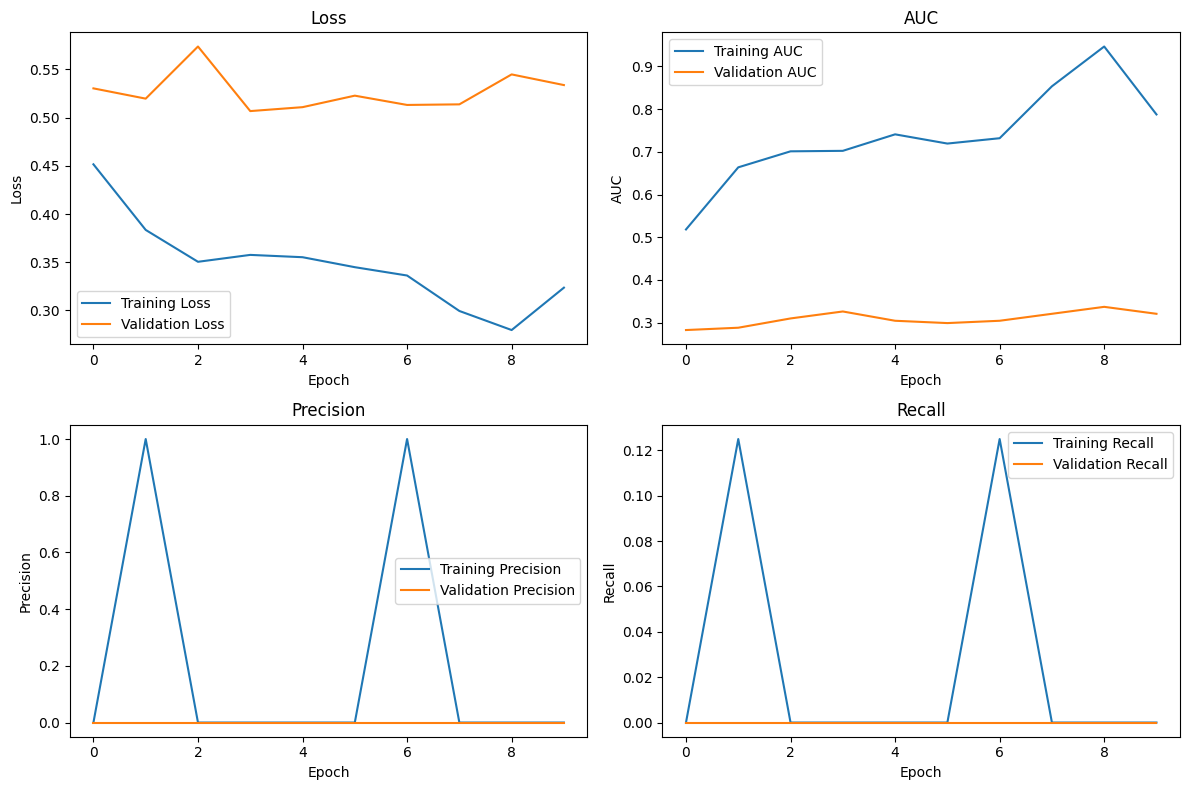

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(2, 2, 2)
plt.plot(history_dict['auc'], label='Training AUC')
plt.plot(history_dict['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Print a few examples from the validation data
for batch in validation_ds.take(1):
    images, labels = batch
    print("Example validation labels:", labels.numpy())


Example validation labels: [0 0 0 0]


## old traininng code

In [ ]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

checkpoints_dir = Path('checkpoints')
checkpoints_dir.mkdir(exist_ok=True)

to_track = 'val_auc'
checkpoint_path = str(checkpoints_dir) + "/sm-{epoch:04d}" + "-{" + to_track + ":4.5f}"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, save_weights_only=False)
]

history = model.fit(
    # training_ds_transformed,
    training_ds,
    steps_per_epoch=n_iter_training,
    validation_data=validation_ds,
    validation_steps=n_iter_validation,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
16/16 [==============================] - 25s 711ms/step - loss: 5.3460 - auc: 0.5000 - accuracy: 0.7937 - val_loss: 9.2392 - val_auc: 0.5000 - val_accuracy: 0.8519
Epoch 2/10
16/16 [==============================] - 4s 280ms/step - loss: 2.4568 - auc: 0.4386 - accuracy: 0.8730 - val_loss: 0.7769 - val_auc: 0.5435 - val_accuracy: 0.8519
Epoch 3/10
16/16 [==============================] - 5s 306ms/step - loss: 0.4881 - auc: 0.4239 - accuracy: 0.8730 - val_loss: 0.4328 - val_auc: 0.5000 - val_accuracy: 0.8519
Epoch 4/10
16/16 [==============================] - 4s 284ms/step - loss: 0.4035 - auc: 0.4216 - accuracy: 0.8730 - val_loss: 0.4260 - val_auc: 0.5000 - val_accuracy: 0.8519
Epoch 5/10
16/16 [==============================] - 5s 310ms/step - loss: 0.3999 - auc: 0.2432 - accuracy: 0.8730 - val_loss: 0.4244 - val_auc: 0.5000 - val_accuracy: 0.8519
Epoch 6/10
16/16 [==============================] - 5s 349ms/step - loss: 0.3958 - auc: 0.3170 - accuracy: 0.8730 - val_loss: 0.4

just for fun ( actuelly to  compare but weeeeeeee ;)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

checkpoints_dir = Path('checkpoints')
checkpoints_dir.mkdir(exist_ok=True)

to_track = 'val_auc'
checkpoint_path = str(checkpoints_dir) + "/sm-{epoch:04d}" + "-{" + to_track + ":4.5f}"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, save_weights_only=False)
]

history = model.fit(
    # training_ds_transformed,
    training_ds,
    steps_per_epoch=n_iter_training,
    validation_data=validation_ds,
    validation_steps=n_iter_validation,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
16/16 [==============================] - 10s 342ms/step - loss: 55.5784 - auc: 0.3943 - accuracy: 0.6825 - val_loss: 1.3949 - val_auc: 0.5000 - val_accuracy: 0.8519
Epoch 2/10
16/16 [==============================] - 5s 297ms/step - loss: 5.4815 - auc: 0.4841 - accuracy: 0.7460 - val_loss: 1.4160 - val_auc: 0.4783 - val_accuracy: 0.8519
Epoch 3/10
16/16 [==============================] - 5s 297ms/step - loss: 0.7995 - auc: 0.4625 - accuracy: 0.8730 - val_loss: 0.4371 - val_auc: 0.3696 - val_accuracy: 0.8519
Epoch 4/10
16/16 [==============================] - 6s 372ms/step - loss: 0.3908 - auc: 0.5682 - accuracy: 0.8730 - val_loss: 0.4417 - val_auc: 0.4348 - val_accuracy: 0.8519
Epoch 5/10
16/16 [==============================] - 5s 297ms/step - loss: 0.4694 - auc: 0.4818 - accuracy: 0.8730 - val_loss: 0.5757 - val_auc: 0.4402 - val_accuracy: 0.8519
Epoch 6/10
16/16 [==============================] - 4s 286ms/step - loss: 0.4360 - auc: 0.4625 - accuracy: 0.8730 - val_loss: 0.

### resnet_50 with dynamic transformation

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from pathlib import Path

# Reading npy file and expanding the dimension for single channel images
def read_npy_file(item):
    data = np.load(item.decode())
    return np.expand_dims(data.astype(np.float32), axis=-1)  # (256, 256, 1)

# Apply transformations dynamically
def apply_transformations(image, label):
    # Rescale intensity (normalize to range [0, 1])
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

    # Add random noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise

    # Random bias field
    bias = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=0.5)
    image = image + bias

    # Random affine transformation
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Replicate the single channel to create 3-channel pseudo-RGB images
    image = tf.tile(image, [1, 1, 3])  # (256, 256, 1) -> (256, 256, 3)

    return image, label

# Create TensorFlow dataset with dynamic transformations
def create_tf_dataset(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    paths = [str(i) for i in df['prepared_path']]
    volumes = tf.data.Dataset.from_tensor_slices(paths).map(lambda item: tf.numpy_function(read_npy_file, [item], [tf.float32])[0])
    labels = tf.data.Dataset.from_tensor_slices(df['prediction'].values)
    zipped = tf.data.Dataset.zip((volumes, labels))

    # Apply transformations lazily (dynamically for each batch)
    transformed_ds = zipped.map(lambda image, label: (apply_transformations(image, label)))

    # Shuffle, batch, and repeat
    ds = transformed_ds.shuffle(len(paths), seed=7).batch(batch_size).repeat()
    return ds

# Example dataset creation
BATCH_SIZE = 4
training_ds = create_tf_dataset(training_df, BATCH_SIZE)
validation_ds = create_tf_dataset(validation_df, BATCH_SIZE)

n_iter_training = (len(training_df) // BATCH_SIZE) + int((len(training_df) % BATCH_SIZE) > 0)
n_iter_validation = (len(validation_df) // BATCH_SIZE) + int((len(validation_df) % BATCH_SIZE) > 0)

# Define model (adjust input to ResNet50)
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))  # 3-channel pseudo-RGB input for ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

# Add final layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Checkpoint callback
checkpoints_dir = Path('checkpoints')
checkpoints_dir.mkdir(exist_ok=True)

to_track = 'val_loss'
checkpoint_path = str(checkpoints_dir) + "/sm-{epoch:04d}" + "-{" + to_track + ":4.5f}"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, save_weights_only=False)
]

# Train the model
history = model.fit(
    training_ds,
    steps_per_epoch=n_iter_training,
    validation_data=validation_ds,
    validation_steps=n_iter_validation,
    epochs=10,
    callbacks=callbacks
)

# Checking a sample batch
for image_batch, label_batch in training_ds.take(1):
    print("Image batch shape:", image_batch.shape)  # Should be (BATCH_SIZE, 256, 256, 3)
    print("Label batch shape:", label_batch.shape)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node Tile defined at (most recent call last):
<stack traces unavailable>
Detected at node Tile defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Expected multiples argument to be a vector of length 4 but got length 3
	 [[{{node Tile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Expected multiples argument to be a vector of length 4 but got length 3
	 [[{{node Tile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_40472]

# Export

## export new :

In [ ]:
import typing
import shutil
from pathlib import Path
import tensorflow as tf

def get_best_checkpoint(checkpoints_dir: Path, export_mode: str) -> typing.Dict:
    """Gets the best checkpoint based on the export mode ('min' or 'max')."""
    checkpoints = get_checkpoints_info(checkpoints_dir)

    if export_mode == 'min':
        selected_model = min(checkpoints, key=lambda x: x['value'])
    else:
        selected_model = max(checkpoints, key=lambda x: x['value'])

    return selected_model

def get_checkpoints_info(checkpoints_dir: Path) -> typing.List[typing.Dict]:
    """Returns info about checkpoints.

    Returns:
        A list of dictionaries related to each checkpoint:
            {'epoch': int, 'path': pathlib.Path, 'value': float}
    """
    checkpoints = _get_checkpoints(checkpoints_dir)

    ckpt_info = []
    for cp in checkpoints:
        if cp.name.endswith('.keras') or cp.name.endswith('.h5'):
            # Extract epoch and metric value from filename
            name_parts = cp.stem.split('-')
            epoch = int(name_parts[1])
            metric_value = float(name_parts[2].split('.')[0])
            ckpt_info.append({'path': cp, 'epoch': epoch, 'value': metric_value})

    return ckpt_info

def _get_checkpoints(checkpoints_dir: Path) -> typing.List[Path]:
    """Returns a list of paths to checkpoint files."""
    checkpoints = []
    for item in checkpoints_dir.iterdir():
        if item.name.endswith('.keras') or item.name.endswith('.h5'):
            checkpoints.append(item)

    return checkpoints

def print_model_info(model_path: Path):
    """Loads and prints information about the model."""
    model = tf.keras.models.load_model(model_path)

    # Print model summary
    print("\nModel Summary:")
    model.summary()

    # Print model's loss and metrics information
    loss = model.loss
    metrics = model.metrics
    print("\nModel Loss and Metrics:")
    print(f"Loss: {loss}")
    for metric in metrics:
        print(f"Metric: {metric}")

# Ensure the export directory exists
export_dir = Path('exported')
export_dir.mkdir(exist_ok=True)

# Get the best checkpoint and copy it to the export directory
best_checkpoint = get_best_checkpoint(checkpoints_dir, 'max')
if best_checkpoint:
    model_path = best_checkpoint['path']

    # Use shutil.copytree for directories; shutil.copy2 for single files
    if model_path.is_dir():
        shutil.copytree(model_path, export_dir / 'model')
    else:
        shutil.copy2(model_path, export_dir / 'model')

    # Print model information
    print_model_info(export_dir / 'model')
else:
    print("No checkpoints found.")


ValueError: max() arg is an empty sequence

## Export the best model:

In [ ]:
import typing
import shutil


def get_best_checkpoint(checkpoints_dir: Path, export_mode: str) -> typing.List[typing.Dict]:
    checkpoints = get_checkpoints_info(checkpoints_dir)

    if export_mode == 'min':
        selected_model = min(checkpoints, key=lambda x: x['value'])
    else:
        selected_model = max(checkpoints, key=lambda x: x['value'])
    return selected_model


def get_checkpoints_info(checkpoints_dir: Path) -> typing.List[typing.Dict]:
    """Returns info about checkpoints.

    Returns:
        A list of dictionaries related to each checkpoint:
            {'epoch': int, 'path': pathlib.Path, 'value': float}

    """

    checkpoints = _get_checkpoints(checkpoints_dir)

    ckpt_info = list()
    for cp in checkpoints:
        if cp.name.endswith('.keras'):
            splits = str(cp.name).split('.keras')[0].split('-')
        else:
            splits = str(cp.name).split('-')
        epoch = int(splits[1])
        metric_value = float(splits[2])
        ckpt_info.append({'path': cp, 'epoch': epoch, 'value': metric_value})
    return ckpt_info


def _get_checkpoints(checkpoints_dir: Path) -> typing.List[Path]:
    """Returns a list of paths to folders containing a ``saved_model.pb``"""

    checkpoints = list()
    for item in checkpoints_dir.iterdir():
        if any(item.glob('saved_model.pb')) or item.name.endswith('.keras'):
            checkpoints.append(item)

    return checkpoints


export_dir = Path('exported')
export_dir.mkdir(exist_ok=True)

best_checkpoint = get_best_checkpoint(checkpoints_dir, 'max')
shutil.copytree(best_checkpoint['path'], export_dir / 'model')

PosixPath('exported/model')

Create a `sumbission.py` file, with following specifications:
- takes two command-line arguments:
    - `data_dir`: path to data directory, which consists of folders of Dicom files, each one corresponding to a Dicom series
    - `predictions_file_path`: path to a `.csv` file which is expected to be generated by your script, and has to contain following columns:
        - `SeriesInstanceUID` (str)
        - `prediction` (float): model's raw prediction
- reads the model file which you have included in your final `.zip` file

let's create our submission file as `exported/submission.py`:

In [ ]:
"""
filename: ``submission.py``
execution: python submission.py --data-dir /path/to/data-dir --predictions-file-path submission.csv
"""
from typing import Optional

import numpy as np
import pandas as pd
import tensorflow.keras as keras
import pydicom
import SimpleITK as sitk
from PIL import Image
import click


HERE = Path(__file__).absolute().resolve().parent


def read_dicom_series(study_path: Path, series_instance_uid: Optional[str] = None) -> np.ndarray:
    """Reads the dicom series and returns the rendered pixel-array, header and dicom file paths.

    Notes:
        - returned array is in haunsfield uints, you have to take care of windowing
    """

    if series_instance_uid is None:
        series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(study_path))[0]
    else:
        series_id = series_instance_uid

    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(study_path), series_id)

    headers = list()
    for fn in series_file_names:
        headers.append(pydicom.dcmread(str(fn), stop_before_pixels=True))

    volume = sitk.ReadImage(
        series_file_names, sitk.sitkInt32
    )
    volume = np.array(sitk.GetArrayFromImage(volume), dtype=np.float32)

    if all([i.get('InstanceNumber') is not None for i in headers]):
        slice_number_tag = 'InstanceNumber'
    elif all([i.get('InstanceNumber') is not None for i in headers]):  # in earlier versions of Dicom
        slice_number_tag = 'ImageNumber'
    else:
        slice_number_tag = None

    if slice_number_tag is not None:
        sorted_headers = sorted(headers, key=lambda x: int(x.get(slice_number_tag)))
        file_name_to_index_mapper = {k: v for v, k in enumerate(series_file_names)}
        sorted_file_names = sorted(
            series_file_names,
            key=lambda x: int(headers[file_name_to_index_mapper[x]].get(slice_number_tag))
        )
    else:
        sorted_headers = headers
        sorted_file_names = series_file_names

    ret = {
        'array': volume,
        'headers': sorted_headers,
        'dcm_paths': sorted_file_names
    }
    return ret


def apply_windowing(series: np.ndarray,
                    window_center: int,
                    window_width: int) -> np.ndarray:
    """Returns an array for given window.

    Args:
        series: numpy array of shape (n_slices, h, w) or (h, w) in haunsfield units.
        window_center: for example, brain window's center is 40
        window_width: for example, brain window's width is 80

    Returns:
        numpy array of shape (n_sclies, h, w) or (h, w) in range(0, 1)

    """

    w_min = int(window_center - (window_width / 2))
    w_max = int(window_center + (window_width / 2))

    clipped = np.clip(series, w_min, w_max)
    windowed = (clipped - w_min) / (w_max - w_min)

    return windowed


def apply_windowing_using_header_on_series(series: np.ndarray, headers: list[pydicom.FileDataset]) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        series: numpy array of shape (num_slices, h, w) in haunsfield units.
        headers: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    windowed_series = list()
    for i, header in enumerate(headers):
        window_center = header.get('WindowCenter')
        window_width = header.get('WindowWidth')
        windowed_series.append(apply_windowing(series[i], window_center, window_width))

    return np.array(windowed_series)


@click.command()
@click.option('--data-dir', type=Path)
@click.option('--predictions-file-path', type=Path)
def main(data_dir: Path, predictions_file_path: Path):
    series_instance_uid_list = [i.name for i in data_dir.iterdir() if i.is_dir()]
    model = keras.models.load_model(str(HERE / 'model'))

    predictions = list()
    for siuid in series_instance_uid_list:
        study_path = DATA_DIR / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])

        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))
        else:
            arr = windowed_series

        if len(arr) != 16:
            remainder = len(arr) - 16
            arr = arr[int(remainder / 2): 16 + int(remainder / 2)]

        prediction = model.predict(np.expand_dims(arr, axis=(0, -1)))[0][0]
        predictions.append(prediction)

    predictions_df = pd.DataFrame({'SeriesInstanceUID': series_instance_uid_list, 'prediction': predictions})
    predictions_df.to_csv(predictions_file_path)


if __name__ == "__main__":
    main()


NameError: name '__file__' is not defined

In [ ]:
from pathlib import Path
from typing import Optional
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import SimpleITK as sitk
from PIL import Image

# Use Colab environment settings
HERE = Path('/content/exported')

def read_dicom_series(study_path: Path, series_instance_uid: Optional[str] = None) -> np.ndarray:
    """Reads the DICOM series and returns the pixel-array, header, and DICOM file paths."""
    if series_instance_uid is None:
        series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(study_path))[0]
    else:
        series_id = series_instance_uid

    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(study_path), series_id)
    headers = [pydicom.dcmread(str(fn), stop_before_pixels=True) for fn in series_file_names]

    volume = sitk.ReadImage(series_file_names, sitk.sitkInt32)
    volume = np.array(sitk.GetArrayFromImage(volume), dtype=np.float32)

    if all([i.get('InstanceNumber') is not None for i in headers]):
        slice_number_tag = 'InstanceNumber'
    else:
        slice_number_tag = 'ImageNumber' if all([i.get('ImageNumber') is not None for i in headers]) else None

    if slice_number_tag:
        sorted_headers = sorted(headers, key=lambda x: int(x.get(slice_number_tag)))
        file_name_to_index_mapper = {k: v for v, k in enumerate(series_file_names)}
        sorted_file_names = sorted(
            series_file_names,
            key=lambda x: int(headers[file_name_to_index_mapper[x]].get(slice_number_tag))
        )
    else:
        sorted_headers = headers
        sorted_file_names = series_file_names

    return {'array': volume, 'headers': sorted_headers, 'dcm_paths': sorted_file_names}

def apply_windowing(series: np.ndarray, window_center: int, window_width: int) -> np.ndarray:
    """Applies windowing to the image data."""
    w_min = int(window_center - (window_width / 2))
    w_max = int(window_center + (window_width / 2))
    clipped = np.clip(series, w_min, w_max)
    return (clipped - w_min) / (w_max - w_min)

def apply_windowing_using_header_on_series(series: np.ndarray, headers: list) -> np.ndarray:
    """Applies windowing based on DICOM header information."""
    windowed_series = [apply_windowing(series[i], header.WindowCenter, header.WindowWidth) for i, header in enumerate(headers)]
    return np.array(windowed_series)

def process_dicom(data_dir: str, predictions_file_path: str):
    data_dir = Path(data_dir)
    predictions_file_path = Path(predictions_file_path)

    series_instance_uid_list = [i.name for i in data_dir.iterdir() if i.is_dir()]
    model = tf.keras.models.load_model(str(HERE / 'model'))

    predictions = []
    for siuid in series_instance_uid_list:
        study_path = data_dir / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])

        target_h, target_w = 256, 256  # Specify target dimensions

        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))
        else:
            arr = windowed_series

        if len(arr) != 16:
            remainder = len(arr) - 16
            arr = arr[int(remainder / 2): 16 + int(remainder / 2)]

        prediction = model.predict(np.expand_dims(arr, axis=(0, -1)))[0][0]
        predictions.append(prediction)

    predictions_df = pd.DataFrame({'SeriesInstanceUID': series_instance_uid_list, 'prediction': predictions})
    predictions_df.to_csv(predictions_file_path)

# Use this function directly in Colab or in a script
if __name__ == "__main__":
    # Example paths for Colab usage
    data_dir = "/root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data"
    predictions_file_path = "/content/drive/MyDrive/IAAA/submission.csv"

    process_dicom(data_dir, predictions_file_path)


OSError: No file or directory found at /content/exported/model

Now make a zip file from `exported` and upload it to evaluation platform.

In [ ]:
! zip -r exported.zip exported/ -x exported/.ipynb_checkpoints/

  adding: exported/ (stored 0%)
  adding: exported/model/ (stored 0%)
  adding: exported/model/saved_model.pb (deflated 90%)
  adding: exported/model/assets/ (stored 0%)
  adding: exported/model/fingerprint.pb (stored 0%)
  adding: exported/model/variables/ (stored 0%)
  adding: exported/model/variables/variables.index (deflated 72%)
  adding: exported/model/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: exported/model/keras_metadata.pb (deflated 94%)


In [ ]:
import Path

ModuleNotFoundError: No module named 'Path'